# Imports and plot properties


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  6 15:24:06 2020

@author: Shiva
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import pandas as pd
from pandas import read_excel
from matplotlib.font_manager import FontProperties
from scipy.ndimage.interpolation import shift
import os
import glob
import timeit
from scipy import stats
import statsmodels.stats.api as sms
from matplotlib.collections import LineCollection
from tempfile import TemporaryFile
import matplotlib.gridspec as gridspec
import seaborn as sns
from statannot import add_stat_annotation
# import numpy_indexed as npi
#print(os.path.dirname(__file__))


#############################   Plot properties   ########################################################


font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size('30')
font.set_weight('bold')

font_label = FontProperties()
font_label.set_family('serif')
font_label.set_name('Times New Roman')
font_label.set_style('italic')
font_label.set_size('25')
font_label.set_weight('bold')


# Functions

In [58]:
def read_DLC_csv(file_name_pos,fp_trial):
    ''' Read DeepLab Cut Data and remove the <half-trial> at the end'''
    
    df = pd.read_csv(file_name_pos, delimiter=",", header=[1,2])*scale_pix_to_cm # scale to cm
    remainer = len(df.index)%fp_trial
    df = df.drop(np.arange(len(df.index)-remainer,len(df.index)))
    return df


def read_LED_csv(file_name_LED):
    ''' Read Laser onsets offsets for Square Pulse'''
    df = pd.read_csv(file_name_LED, delimiter=",")
    return df


# uncomment for beta stim

# def read_laser(file_name_laser):
#     ''' Read Laser onsets offsets for Beta Stim'''
# #    file_name_laser = direct+ '/Laser/Mouse' +str(mouse_no)+ '_'+brain_region+'_alone_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
#     laser_t = pd.read_excel(file_name_laser, skiprows = 4 )
#     onset = np.array(laser_t['ON'].values)
#     starts = np.where(shift(onset, -1, cval= 0)-onset > between_stim) # find the starts of sessions if 
#                                     # they are not oscilations of a beta wave
    
#     temp = np.zeros((len(onset[starts[0]])+1,))
#     temp[0] = onset[0] # save the first detected laser as the dtart of the first session

#     temp[1:temp.shape[0],]= onset[starts[0]+1] # the rest are as detected above

#     df = pd.DataFrame(({'ON':temp, 
#                         'OFF':temp+interval}))
#     return df

def list_all_files(path,extension):
    '''get all the files with extention in the path where you want to search
        if found csvs convert to xlsx'''
    files = [x for x in os.listdir(path) if not x.startswith('.')]
    files.sort()
    return list(filter(lambda x: extension in x, files))

def convert_csv_to_xlsx(path):
    '''check if the directory has all the files in this format, if not convert to this format
        and remove the csv to save space'''
    files = [x for x in os.listdir(path) if not x.startswith('.')]
    files.sort()
    csv_files = list(filter(lambda x: ".csv" in x, files))
    csv_file_names = [x.replace(".csv","") for x in csv_files] # remove extensions to be able to compare lists
    xlsx_files = list(filter(lambda x: extension in x, files))
    xlsx_file_names = [x.replace(".xlsx","") for x in xlsx_files]
    if not set(csv_file_names) < set(xlsx_file_names): # if most files are in csv convert them to xlsx

        for filepath_in in csv_files:
            name = path+"/"+filepath_in

            try:
                pd.read_csv(name, delimiter=",").to_excel(path+"/"+filepath_in.replace(".csv",".xlsx"), header = True,index = False)
            except pd.errors.ParserError: # it must be a laser file
                pd.read_csv(name, delimiter=",",skiprows= 4).to_excel(path+"/"+filepath_in.replace(".csv",".xlsx"), startrow=4, header = True, index = False)

            os.remove(name) # remove the csv file.
            
        
def save_npz(mouse_type,opto_par,folder,pulse_inten, window,n_timebin,file_name_ext,
             epochs_all_mice, epochs_mean_each_mouse, epochs_spont_all_mice):
    '''save the trial epochs in npz
        1: all of laser sessions one mouse type
        2: average for each mouse in mouse type
        3: eauivalent number of laser sessions derived from spontaneous '''
    file_name = mouse_type+'_'+opto_par+'_'+pulse_inten+file_name_ext+"_mov_aver="+str(window)+"_n_t="+str(n_timebin)
    np.savez( os.path.join(pre_direct+'data_npz/'+folder+'/'+opto_par, file_name),
             epochs_all_mice=epochs_all_mice,
             epochs_mean_each_mouse=epochs_mean_each_mouse, 
             epochs_spont_all_mice=epochs_spont_all_mice)
#     dat = npzfile = np.load(pre_direct+'data_npz/'+file_name+'.npz')
#     dat.files
    
def moving_average_array(X, n):
    ''' function to return the moving average with same dimentions'''
    z2= np.cumsum(np.pad(X, (n,0), 'constant', constant_values=0))
    z1 = np.cumsum(np.pad(X, (0,n), 'constant', constant_values=X[-1]))
    return (z1-z2)[(n-1):-1]/n

def align_right_left(right,left):
    ''' correct if for any reason there has been a shift between labelings of right and left side'''
    delta = np.average(right-left)
    if delta > 0: # if the right is ahead
        right -=delta/2 ; left += delta/2
    else: # if the left is ahead
        right +=delta/2 ; left -= delta/2
    return right,left


def compare_r_l_correct_misdetect (right_p, left_p, acc_deviance, t_s):
    ''' compare between the right and left sides and adjust the outlier 
        setting the acceptable deviance of left from right and t_s the number of 
        procedeeing and past time bins to average from and correct the misdetection with'''
    right_x = np.copy(right_p); left_x = np.copy(left_p) ### if not it changes the df that was passed to the function along with the right_x and left_x
    r_x = np.copy(right_x)
    l_x = np.copy(left_x)
    delta_x = np.absolute(right_x - left_x) # the difference between detections of right and left cameras
    ind, = np.where(delta_x > internal_ctr_dev)
    
    if len(ind)> percent_thresh_align*len(right_x):# if more than a percentage of detections are not aligned there must be a shift
        print("in")
        right_x, left_x = align_right_left(right_x,left_x)
        
    delta_x = np.absolute(right_x - left_x) 
    mis_r_l, = np.where(delta_x > acc_deviance) # spot where  
    removed_edge_ind = np.logical_and((mis_r_l > t_s+1), (mis_r_l <(len(right_x)-t_s-1)))
    mis_r_l = mis_r_l[removed_edge_ind]
#     print(mis_r_l)
    # spot which is more deviant from it's neghbors in time
    print("# inconsistent right left = ",len(mis_r_l))
#     print("time stamps = ", mis_r_l[(mis_r_l>34.5*fps) & (mis_r_l<35*fps)]/fps)
    if len(mis_r_l) > 0: # only bother if only you find any mismatches
        compare_within_r = np.zeros((delta_x.shape))
        compare_within_l = np.zeros((delta_x.shape))
        bef_r = np.hstack([ np.absolute(np.average(right_x[j-t_s:j-1])-right_x[j])+
                np.absolute(np.average(right_x[j+1:j+t_s])-right_x[j]) for j in mis_r_l ])/2
        bef_l = np.hstack([ np.absolute(np.average(left_x[j-t_s:j-1])-left_x[j])+
                np.absolute(np.average(left_x[j+1:j+t_s])-left_x[j]) for j in mis_r_l ])/2
        compare_within_r[mis_r_l] = bef_r
        compare_within_l[mis_r_l]= bef_l

        ind_right_larger, =np.where(compare_within_l < compare_within_r) 
        ind_left_larger, =np.where(compare_within_l > compare_within_r) 

        temp_r = np.in1d(mis_r_l,ind_right_larger)
        ind_r_corr = mis_r_l[temp_r] # where there's mismatch and it's annonated to the right one
        temp_l = np.in1d(mis_r_l,ind_left_larger)
        ind_l_corr = mis_r_l[temp_l] # where there's mismatch and it's annonated to the left one
        # correct based on the findings
        # set to the average of the other side rather than the same track because there's a better chance the
        # mistake happens again in the proximity of the same side
        if len(ind_l_corr) > 0 :
            left_x[ind_l_corr] = np.hstack([np.average( right_x[j-t_s:j-1] ) +
                                       np.average( right_x[j+1:j+t_s] ) for j in ind_l_corr])/2
        if len(ind_r_corr) > 0 :
            right_x[ind_r_corr] = np.hstack([np.average( left_x[j-t_s:j-1] ) +
                                       np.average( left_x[j+1:j+t_s] ) for j in ind_r_corr])/2

    return np.array(right_x).reshape((-1, 1)), np.array(left_x).reshape((-1, 1))


def correct_labeling_jitter(x, jitter_threshold, n_iter,t_s):
    ''' correct the detections exceeding the max speed of the mouse with
        the average of before and after time stamps 
        '''
    for i in range(n_iter):
        deltas = x - shift(x, 1, cval= x[0])
        ind, = np.where(np.absolute(deltas) > jitter_threshold)
        ind = ind[(ind > t_s+1) & (ind <(len(x)-t_s-1))]
        if len(ind) > 0: # if jumped in detection set to the mean of <t_s> previous and next detections
            x[ind] = np.hstack([np.average(x[j-t_s:j-1])+np.average(x[j+1:j+t_s]) for j in ind])/2
            print("# jitter in mean(righ,left)  = ", len(ind))                                     
#     print("nan found? How many? ",sum(np.isnan(x)))
#     print(x[ind])
    return x


def average_position_r_l(df,which_plot,where_plot):
    ''' average over right and left on the selected body parts 
        and remove jitters with "compare_r_l_correct_misdetect" and afterwards
        "correct_labeling_jitter"'''
#     df_copy = df.copy(deep=True)
    cor_list = np.array(['x', 'y'])
    cor = cor_list[which_plot] # gets either x or y by user
    body_part_list = body_part[where_plot]
    averaged_position = np.zeros((df[('r'+body_part[0],cor)].values.shape,1))
    
    for param in body_part_list : # average over body parts
        right_x = np.copy(df[('r'+param,cor)].values)
        left_x = np.copy(df[('l'+param,cor)].values)
        right, left = compare_r_l_correct_misdetect(right_x,left_x,acc_deviance,t_s) #first compare r and l
        left_right_corrected_averaged = np.average(np.concatenate((right,left),axis = 1),axis=1)
        # (this corrects when the misdetection happened for both left and right because
        # left and right have already been aligned together)
        averaged_position += correct_labeling_jitter(left_right_corrected_averaged,jitter_threshold,n_iter_jitter, t_s)
    
    averaged_position = averaged_position/len(body_part_list)

    return   moving_average_array(averaged_position, window)

def average_position(df,cor,where_plot,r_or_l):
    ''' average over the selected body parts '''
    
    body_part_list = body_part[where_plot]
    averaged_position = np.zeros((len(df.index),1))
    for param in body_part_list : # average over body parts
        x = np.copy(df[(r_or_l+param,cor)].values).reshape(-1,1)
#         averaged_position += correct_labeling_jitter(left_right_corrected_averaged,jitter_threshold,n_iter_jitter, t_s)
        averaged_position += x
    averaged_position = averaged_position/len(body_part_list)
    return   averaged_position#moving_average_array(averaged_position, window)
 
def derivative(x,delta_t):
    ''' take the derivative with delta_t '''
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ (delta_t/fps)
    ## got crazy zith keyerror -1 
#     print(derivative_out[-1])
#     return shift(derivative_out,-int(delta_t/2),cval= derivative_out[-1])
    return shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])

def derivative_mov_ave(x,delta_t,window):
    ''' take the derivative with delta_t and do a moving average over the window'''
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ (delta_t/fps)
    dx_dt = shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])
#     moving_aver = np.convolve(dx_dt, np.ones((window,))/window, mode='valid')
    return moving_average_array(dx_dt, window_veloc) # return the moving average
#     return dx_dt # if you don't want to do a moving average 


# def detect_remove_jitter(velocity):
#     ''' detect when the DLC labeled wrongly by filtering with acceleration criteria
    
#     to do: set the inconsistent one to the average of before and after'''
#     shifted = shift(velocity, 1, cval= velocity[0])
#     accel = (velocity - shifted)/(1/fps)
#     print(np.sort(accel)[-2])
#     print("max accel = ", max(accel), np.argmax(accel)/fps)
#     ind = np.where(np.absolute(accel) > max_accel)
#     print("# jitters in speed = ",len(ind[0]))
#     return velocity

def input_plot(df, laser_t):
    ''' get the specifics of the plot as input and call the corresponding plot function '''
    
    print("Select what you want to see: \n")
    print(" 1. Tail \n 2. Nose \n 3. Fore Limb \n 4. Hind Limb")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
    
    print(" 1. Position \n 2. Velocity \n 3. Acceleration")
    what_plot = int(input())-1 # ask what body part to plot
    
    print(" 1. X \n 2. Y ")
    which_plot = int(input())-1 # ask what body part to plot
    
    print(" 1. Right & Left \n 2. Average")
    Average_sep_plot = int(input()) # ask what body part to plot
    
    if Average_sep_plot == 2:
        print(Average_sep_plot)
        plot_what_which_where(df, laser_t, np.array(which_plot),np.array(what_plot),np.array(where_plot))
    else:
        plot_what_which_where_r_l(df, laser_t, np.array(which_plot),np.array(what_plot),np.array(where_plot))
        
def get_input_cor_body_part():
    ''' ask for the body part and coordinate from user'''
    
    print("Select for which parts you want to see the trial: \n")
    print(" 1. finger 0 \n 2. finger 1 joint \n 3. finger 1 base \n 4. finger 2 joint \n 5. finger 2 base")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
#     print(" 1. X \n 2. Y ")
#     which_plot = int(input())-1 # ask what body part to plot
    print(" 1. Position \n 2. Velocity \n ")
    what_plot = int(input())-1 # ask what body part to plot
    return where_plot,what_plot

def produce_random_bins_for_spont(max_time,n_sample,max_distance,min_distance):
    ''' produce a grid for start of bins then perturb to have randomly 
    spaced trials with a minimum and maximum distance between them'''
    
    half_max_distance =int(max_distance/2)
    start = pre_interval + half_max_distance # the first timebin eligible for the start of the first timebin
    end = max_time - (post_interval+interval+half_max_distance) # the last timebin eligible for the start of the last trial 
    time_points = np.arange(start, end-((end-start)%(min_distance+half_max_distance)),min_distance+half_max_distance ) # produce the grid
    perturb = np.random.randint(-half_max_distance,half_max_distance, size = (n_sample,len(time_points))) # produce the random perturbations
    start_arr = np.repeat(time_points.reshape(1,len(time_points)),n_sample,axis = 0)+perturb # perturb the starting points
    starts = (np.array(start_arr.ravel())).reshape(len(start_arr.ravel()),1)
    ends = starts+interval
    bins = np.concatenate((starts,ends),axis = 1) #stack start and ends of bins

    return bins

def extract_epochs(bins,x,pre_interval,post_interval,interval):
    ''' extract the (pre | Laser ON | post) epochs '''
    bins_in = np.copy(bins)
    ### remove the unacceptable epochs
    duration = bins_in[:,1]-bins_in[:,0]
    acceptable = np.logical_and(duration>smallest_accep_inter,duration<largest_accep_inter)

    print("# discarded epochs =",len(acceptable)-sum(acceptable))
    bins_in = bins[acceptable,:]

    ### find the epochs != interval 
    larger_intervals = (duration[acceptable])>interval # find the exterior intervals to the standard interval
    smaller_intervals = (duration[acceptable])<interval # find the inferior intervals to the min interval
    
    # remove or add the extra frames  to make it uniform along the different stimuli
    bins_in[larger_intervals,1] = bins_in[larger_intervals,1] - (bins_in[larger_intervals,1]-bins_in[larger_intervals,0]-interval)
    bins_in[smaller_intervals,1] = bins_in[smaller_intervals,1] + (interval-(bins_in[smaller_intervals,1]-bins_in[smaller_intervals,0]))
    bins_in[:,1] = bins_in[:,0] + interval + post_interval; bins_in[:,0] = bins_in[:,0] - pre_interval  # extend the interval to pre and post

    take = np.hstack([np.arange(i[0],i[1]+1) for i in bins_in[:-1]]) # make an array with indices of laser ON timebins
    epochs = x[take].reshape(len(bins_in)-1,pre_interval+post_interval+interval+1)
    return epochs

def extract_epochs_over_trials(files_list,direct,folder,fp_trial):
    '''return all the epochs of all trials for one mouse '''
    plot_param_list = ['position' , 'velocity', 'acceleration']
    global plot_param
    plot_param = plot_param_list[what_plot]
#     epochs_x = np.empty((0,pre_interval+post_interval+interval+1))
#     epochs_y = np.empty((0,pre_interval+post_interval+interval+1))
    epochs_x = np.empty((0,fp_trial))
    epochs_y = np.empty((0,fp_trial))
    for i in range(0,len(files_list)):
        
        print(' number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = direct+folder+'/'+files_list[i]
        df = read_DLC_csv(file_path_DLC)
        
        if plot_param == 'position':
#             variable = average_position_r_l(df, which_plot,where_plot)
            variable_x = average_position(df, 'x',where_plot,r_or_l)
            variable_y = average_position(df, 'y',where_plot,r_or_l)
        if plot_param == 'velocity':
            variable =  derivative_mov_ave(average_position(df, which_plot,where_plot,r_or_l),n_timebin,window)  # velocity
#             variable = detect_remove_jitter(variable)

        start = np.arange(0,len(df.index),fp_trial)
        start = start[:-1]
        end = start+fp_trial
        bins  = np.concatenate((start.reshape(-1,1),end.reshape(-1,1)),axis = 1)
        epochs_trial_x = variable_x[:end[-1]].reshape(len(start),fp_trial)
        epochs_trial_y = variable_y[:end[-1]].reshape(len(start),fp_trial)

#         epochs_trial = extract_epochs(bins,variable,pre_interval,post_interval,interval)
        epochs_x = np.append(epochs_x,epochs_trial_x,axis = 0)
        epochs_y = np.append(epochs_y,epochs_trial_y,axis = 0)

#     if plot_param == 'position':
#         return epochs- np.repeat(epochs[:,0].reshape(epochs.shape[0],1),epochs.shape[1],axis = 1)
#     else:
    return epochs_x,epochs_y

def min_and_mean_on_off(epochs,pre_interval,post_interval,interval,measure):
    ''' report the min or mean (specified by measure) velocity in the off-on periods'''
    
    if measure =='Mean':
        try:
            pre = np.average(epochs[:,0:pre_interval],axis = 1).reshape(epochs.shape[0],1)
            ON = np.average(epochs[:,pre_interval:pre_interval+interval],axis = 1).reshape(epochs.shape[0],1)
            post = np.average(epochs[:,pre_interval+interval:pre_interval+interval+post_interval],axis = 1).reshape(epochs.shape[0],1)

        except ZeroDivisionError:
            pre = np.zeros((epochs.shape[0],1))
            ON = np.zeros((epochs.shape[0],1))
            post = np.zeros((epochs.shape[0],1))
    elif measure =='Min':
        try:
            pre = np.average(epochs[:,0:pre_interval],axis = 1).reshape(epochs.shape[0],1)
            ON = np.min(epochs[:,pre_interval:pre_interval+interval],axis = 1).reshape(epochs.shape[0],1)
            post = np.average(epochs[:,pre_interval+interval:pre_interval+interval+post_interval],axis = 1).reshape(epochs.shape[0],1)
        except ZeroDivisionError:
            pre = np.zeros((epochs.shape[0],1))
            ON = np.zeros((epochs.shape[0],1))
            post = np.zeros((epochs.shape[0],1))
    average_of_on_off_on = np.concatenate((pre, ON, post), axis = 1)
    return average_of_on_off_on

def plot_what_which_where_r_l(df,laser_t, which_plot,what_plot,where_plot):
    ''' choose which body part/
                what measure/
                for x or y
        to see the left vs. right
    '''
    label_1 = "Right" 
    label_2 = "left "

    ###%%%%%%%%%%%%%%%% |||||| Choose either x or y ||||||| %%%%%%%%%%%%%%%%%
    cor_list = np.array(['x', 'y'])
    cor = cor_list[which_plot]
    ###%%%%%%%%%%%% |||||| Choose velocity or position ||||||| %%%%%%%%%%%%%%
    plot_param_list = ['position' , 'velocity', 'acceleration']
    plot_param = plot_param_list[what_plot]
    body_part = np.array(['Tail',  'Nose', 'FL', 'HL'])
    param = body_part[where_plot[0]]
    
    
    if plot_param == 'velocity':
        
        velocity_r = derivative_mov_ave(df[('r'+param,cor)], n_timebin, window)
        velocity_l = derivative_mov_ave(df[('l'+param,cor)], n_timebin, window)
        plt.plot(time_series+n_timebin/fps, velocity_r, 'navy',label = label_1, linewidth = 0.8)
        plt.plot(time_series+n_timebin/fps, velocity_l, 'orangered',label = label_2, linewidth = 0.8)
        plt.xlim(n_timebin/fps, trial_time/2)
        plt.ylabel(cor+ " Velocity (cm/s)" ,fontproperties=font_label)
        min_end = min(min(velocity_r),min(velocity_l))
        max_end = max(max(velocity_r),max(velocity_l))
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
        
    elif plot_param == "acceleration":
        
        accel_r = derivative_mov_ave(derivative_mov_ave(df[('r'+param,cor)],n_timebin,window),n_timebin,window)
        accel_l = derivative_mov_ave(derivative_mov_ave(df[('l'+param,cor)],n_timebin,window),n_timebin,window)
        t_shift = n_timebin/fps/2
        plt.plot(time_series+t_shift+t_shift, accel_r, 'navy',label = label_1, linewidth = 0.8)
        plt.plot(time_series+t_shift+t_shift, accel_l, 'orangered',label = label_2, linewidth = 0.8)
        plt.xlim(t_shift+t_shift, trial_time/2)
        plt.ylabel(cor+ " Acceleration (cm/s2)" ,fontproperties=font_label)
        min_end = min(min(accel_r),min(accel_l))
        max_end = max(max(accel_r),max(accel_l))
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
        
    else:
        
        r,l = compare_r_l_correct_misdetect (df[('r'+param,cor)].values, df[('l'+param,cor)].values, acc_deviance, t_s)
        plt.plot(time_series, r-5, 'k',  marker = 'o', label = label_1,markersize=1)
        plt.plot(time_series, l-5, 'g', label = label_2, marker = 'o', linewidth = 0.8, markersize=1)

        plt.plot(time_series, df[('r'+param,cor)], 'navy',  marker = 'o', label = label_1,markersize=1)
        plt.plot(time_series, df[('l'+param,cor)], 'orangered', label = label_2, marker = 'o', linewidth = 0.8, markersize=1)
        

        plt.xlim(min_x,max_x)
        plt.ylim(min_y,max_y)

        plt.ylabel(cor+ " (cm)" ,fontproperties=font_label)
        min_end = min(min(df[('r'+param,cor)]),min(df[('l'+param,cor)]))
        max_end = max(max(df[('r'+param,cor)]),max(df[('l'+param,cor)]))
            
        
    plt.xlabel("Time(s)" ,fontproperties=font_label)
    plt.title(plot_param+' #'+str(mouse_no)+'\n'+param,fontproperties=font)
    plt.legend(fontsize = 20)
#     plt.ylim(min_end,max_end)
    for i in range(len(laser_t['ON'].values)):
        plt.axvspan(laser_t['ON'].values[i]/fps, laser_t['OFF'].values[i]/fps, alpha=0.2, color='orange')
#     plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'orange', linewidth = 0.4) # plot stimulus onsets
#     plt.vlines(laser_t['OFF']/fps,min_end,max_end, color = 'orange', linewidth = 0.4) # plot stimulus offsets

    plt.savefig(pre_direct+"One_session/"+'/Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_'+
                param + '_' + plot_param + '_' +cor+ '.png',bbox_inches='tight',orientation='landscape',dpi=300)



def plot_what_which_where(df,laser_t, which_plot,what_plot,where_plot):
    ''' choose to see averaged velocity, position or acceleration for a chosen combination of body_parts
        for either x or y
    '''
    ###%%%%%%%%%%%%%%%% |||||| User Chooses either x or y ||||||| %%%%%%%%%%%%%%%%%
    cor_list = np.array(['x', 'y'])
    cor = cor_list[which_plot] # gets either x or y by user
    ###%%%%%%%%%%%% |||||| User Chooses velocity or position ||||||| %%%%%%%%%%%%%%
    plot_param_list = ['position' , 'velocity', 'acceleration']
    plot_param = plot_param_list[what_plot]
    ########################################################################
    body_part = np.array(['Tail', 'Nose', 'FLimb', 'HLimb']) # all body left
    averaged_x = average_position(df, which_plot,where_plot,r_or_l)
    averaged_y = average_position(df, which_plot,where_plot,r_or_l)
    time_series  = df.index / fps
    trial_time = max(time_series)
    
    if plot_param == "velocity":
        
        velocity = derivative_mov_ave((averaged_x^2+averaged_y^2)^0.5,n_timebin,window)
        plt.plot(time_series+n_timebin/fps/2, velocity, 'k', linewidth = 2, label = body_part[where_plot]) # plot all body
        plt.xlim(35,65)
        plt.ylabel(cor+ " Velocity (cm/s)" ,fontproperties=font_label)
        min_end = min(velocity)
        max_end = max(velocity)
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
    
#     elif plot_param == "acceleration":
        
#         accel = derivative_mov_ave(derivative_mov_ave(averaged_pos,n_timebin,window),n_timebin,window)
#         t_shift = n_timebin/fps/2
#         plt.plot(time_series+t_shift+t_shift, accel, 'k', linewidth = 2, label = body_part[where_plot]) # plot all body
#         plt.xlim(t_shift+t_shift, trial_time/2)
#         plt.ylabel(cor+ " Acceleration (cm/(s2))" ,fontproperties=font_label)
#         min_end = min(accel)
#         max_end = max(accel)
#         plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
        
    else:
        plt.plot(averaged_x, averaged_y, '-k', linewidth = 1, label = body_part[where_plot],markersize = 1) # plot all body        
        plt.xlim(min_x,max_x)
        plt.ylabel(cor+ " (cm)" ,fontproperties=font_label)
        min_end = min(averaged_pos)
        max_end = max(averaged_pos)
        
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20)
    ax.yaxis.set_ticks_position('left')
    
    plt.xlabel("Time(s)" ,fontproperties=font_label)
    plt.title("Average "+plot_param+' #'+str(mouse_no)+"\n"+mouse_type+" "+opto_par,fontproperties=font)
    plt.legend(fontsize = 20)
    plt.ylim(min_end,max_end)
    for i in range(len(laser_t['ON'].values)):
        plt.axvspan(laser_t['ON'].values[i]/fps, laser_t['OFF'].values[i]/fps, alpha=0.4, color='lightskyblue')
#     plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'darkskyblue', linewidth = 0.4) # plot stimulus onsets
#     plt.vlines(laser_t['OFF']/fps,min_end,max_end, color = 'darkskyblue', linewidth = 0.4) # plot stimulus offsets
    plt.savefig(pre_direct+"One_session/"+'Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_' +cor+ '_' +
                plot_param+ '_averaged_all_body.png',bbox_inches='tight',orientation='landscape',dpi=300)


 ###################  looking at the pre/on/post stimulus behavior #########################
def plot_pre_on_post(epochs_x,epochs_spont_x,epochs_y,epochs_spont_y,average):
    ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    

#     epochs_sem = stats.sem(epochs, axis=0) # SEM 
#     epochs_sem_spont = stats.sem(epochs, axis=0) # SEM 

#     confidence_inter_x = np.empty((0,2), int)
#     confidence_inter_y = np.empty((0,2), int)
#     confidence_inter_spont_x = np.empty((0,2), int)
#     confidence_inter_spont_y = np.empty((0,2), int)
#     if len(epochs_x.shape) > 1 :
#         epochs_mean_x = np.average(epochs_x, axis = 0)
#         epochs_mean_spont = np.average(epochs_spont_x, axis = 0)
#         epochs_mean_y = np.average(epochs_y, axis = 0)
#         epochs_mean_spont_y = np.average(epochs_spont_y, axis = 0)
#         for i in range (epochs_x.shape[1]): #calculate the two sided confidence interval for every timestep
#             m = [sms.DescrStatsW(epochs_x[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
#             confidence_inter_x = np.append(confidence_inter_x,[[m[0][0],m[0][1]]],axis=0)
#             m = [sms.DescrStatsW(epochs_y[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
#             confidence_inter_y = np.append(confidence_inter_y,[[m[0][0],m[0][1]]],axis=0)
        
# #         for i in range (epochs_spont.shape[1]):
# #             m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
# #             confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
#     else:
#         epochs_mean = epochs
#         epochs_mean_spont = epochs_spont
#         confidence_inter = np.zeros(((epochs_mean.shape[0]),2))
#         confidence_inter_spont = np.zeros((epochs_mean.shape[0],2))
#     time_series = np.arange(fp_trial)/fps
    for i in range(0,epochs_x.shape[0]):
        plt1,=plt.plot(epochs_x,epochs_y, color = 'lightskyblue', linestyle='-',linewidth=2, alpha=0.2)#, marker='o',markersize=1)
    
    plt1,=plt.plot(epochs_mean_x,epochs_mean_y, color = 'k', linestyle='-',linewidth=3, alpha=1)#, marker='o',markersize=1)

#     plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color='deepskyblue', alpha=0.2)
    
#     plt2,=plt.plot(time_series, epochs_mean_spont, color = 'k', label = "Spontaeous")
#     plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color='k', alpha=0.2)
#     plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')
    
#     plt.fill_between(time_series, epochs_mean - epochs_sem,  epochs_mean+ epochs_sem,
#                     color='gray', alpha=0.2)
#     plt.fill_between(time_series, epochs_mean_spont - epochs_sem_spont,  epochs_mean_spont+ epochs_sem_spont,
#                    color='b', alpha=0.2)

    if plot_param_list[what_plot] == 'velocity':
        plt1,=plt.plot(time_series, epochs_mean_x, color = 'deepskyblue', label = body_part[where_plot], linestyle='-',linewidth=2)#, marker='o',markersize=1)
        plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color='deepskyblue', alpha=0.2)

        plt2,=plt.plot(time_series, epochs_mean_spont, color = 'k', label = "Spontaeous")
        plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color='k', alpha=0.2)
        plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')

        plt.ylabel(" Velocity (cm/s)").set_fontproperties(font_label)
        plt.xlabel("Time(s)").set_fontproperties(font_label)
    else:
        plt.ylabel(" y (cm)").set_fontproperties(font_label)
        plt.xlabel("x (cm)").set_fontproperties(font_label)


#     plt.ylim(min_y_pre_post,max_y_pre_post) #set limits
    plt.legend(fontsize = 10)


    if average == 'n':
        ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
        ax.xaxis.set_ticks_position('bottom')
        ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
        ax.yaxis.set_ticks_position('left')
        plt.title(plot_param_list[what_plot]+"("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n").set_fontproperties(font)
        plt.savefig(pre_direct+direct_comparison+'/Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+plot_param
                    +'_timebin_'+str(n_timebin)+'_window_'+str(window)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=300)
    elif average == 'Averg_trials': # one one mouse
        plt.title("("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n"+folder).set_fontproperties(font)
#         plt.title(" #"+str(mouse_no) +" "+mouse_type , fontproperties=font)
#         plt.savefig(pre_direct+direct_comparison+'/'+average+'_Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +str(n_timebin)+ 'spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
    else:
        ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
        ax.xaxis.set_ticks_position('bottom')
        ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
        ax.yaxis.set_ticks_position('left')
#         plt.legend(handles=[plt1,plt2],labels=['Laser Stimulation','Spontaneous'],loc = 'lower right',fontsize =20)
        plt.title( "Rat # "+str(rat_no)+'\n'+folder).set_fontproperties(font)

#         plt.savefig(path+'/'+average+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +
#                     str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.pdf',bbox_inches='tight',
#                     orientation='landscape',dpi=300)

def epochs_single_file(file_name_pos,file_name_spont,file_name_laser):
    '''read a single file for a mouse and return the epochs'''
    
    df = read_DLC(file_name_pos)
    df_spont = read_DLC(file_name_spont)
    laser_t = read_laser(file_name_laser)


    time_series  = df.index / fps ## time axis in seconds for stimulation trial
    trial_time = max(time_series)

    time_series_spont  = df_spont.index / fps ## time axis in seconds for spontaneous activity
    trial_time_spont = max(time_series_spont)

    #input_plot() 
    velocity = derivative(average_position_r_l(df, which_plot,where_plot).values,n_timebin)  # velocity
    bins  = np.array(laser_t.values).astype(int)
    epochs = extract_epochs(bins,velocity,pre_interval,post_interval,interval)
    velocity_spont = derivative(average_position_r_l(df_spont, which_plot,where_plot).values,n_timebin)  # velocity 
    bins_spont  = np.array(laser_t.values).astype(int) # for now
    epochs_spont = extract_epochs(bins,velocity_spont,pre_interval,post_interval,interval)
    return epochs,epochs_spont


def extract_pre_laser_x_epochs_over_trials(files_list,files_list_laser,direct,folder,pre_stim_inter):
    '''return all the x positions in epochs preceding to a ON-laser of all trials for one mouse '''

    i = 0
    epochs = np.empty((0,pre_stim_inter))

    for i in range(0,len(files_list)):
        
        print('x number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = direct+folder+'/DLC/'+files_list[i]
        df = read_DLC(file_path_DLC)
        x_average = average_position_r_l(df, which_plot,where_plot) # x positions
        file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
        laser_t = read_laser(file_path_Laser)
        bins  = np.copy(laser_t.values).astype(int)
        duration = bins[:,1]-bins[:,0]
        acceptable = np.logical_and(duration>smallest_accep_inter,duration<largest_accep_inter)
        print("# x discarded epochs =",len(acceptable)-sum(acceptable))
        bins = bins[acceptable,:]
        
        take = np.hstack([np.arange(i[0]-pre_stim_inter,i[0]) for i in bins[:-1]]) # make an array with indices of laser ON 
        pre_x_series = x_average[take]
        # calculate the x position relative to the front edge of the treadmill
        epochs_trial = np.absolute(pre_x_series-max(pre_x_series)).reshape(len(bins)-1,pre_stim_inter)        
        epochs = np.append(epochs,epochs_trial,axis = 0)
#         print("x = ",epochs_trial.shape)
    return epochs


    
def plot_every_mouse_mean(epochs_mean_each_mouse):
    '''plot mean of each mouse for epochs OFF-ON-OFF'''
    
    for i in range (epochs_mean_each_mouse.shape[0]):
        plt.plot(median,epochs_mean_each_mouse[i,:],'-',color = 'gray',marker = '.')

def violin_plot_summary(data_init,names,measure):
    ''' plot violin plot for different columns in data'''

    def set_axis_style(ax, labels):
        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        ax.set_xlabel('Time Epoch')

    # transform the data into list as to be fed to the violin plot function
    data = list([data_init[:,i] for i in range(data_init.shape[1])])
    fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), sharey=True)

    ax2.set_title(mouse_type)
    parts = ax2.violinplot(data, widths=0.3, showmeans=False, showmedians=False,showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor('teal')
        pc.set_edgecolor('None')
        pc.set_alpha(.4)

    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)

    inds = np.arange(1, len(medians) + 1)
    confidence_inter = np.empty((0,2), int)

    for i in range (data_init.shape[1]): #calculate the two sided confidence interval for every timestep
        m = [sms.DescrStatsW(data_init[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
        confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)

    ax2.scatter(inds,np.average(data_init,axis=0), marker='o', color='white', s=20, zorder=3, label = 'Means') # measns
    ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2, label = 'Quartiles') # quartiles

    ax2.errorbar(inds, np.average(data_init,axis=0),yerr=confidence_inter.T,fmt='none', elinewidth=2, capsize=7,marker='o', color='r',label = '95% Confidence interval') # confidence interval

#     ax2.boxplot(inds, data)
#     ax2.vlines(inds, np.min(data_init,axis=0), np.max(data_init,axis=0), color='r', linestyle='-', lw=1,label = 'Whiskers')
# 
    # set style for the axes
    set_axis_style(ax2, names)
    print(epochs_mean_each_mouse.shape)
    
    # plot each mouse data individually on top of the summary of all
    if measure == 'Mean':
        for i in range (epochs_mean_each_mouse.shape[0]):
            plt.plot(inds,epochs_mean_each_mouse[i,:],'-',color = 'gray',marker = 'o',fillstyle='none',markersize=10,linewidth=2,alpha=0.6)
    elif measure == 'Min':
        for i in range (epochs_min_each_mouse.shape[0]):
            plt.plot(inds,epochs_min_each_mouse[i,:],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
            
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    plt.ylabel(" Velocity (cm/s)", fontproperties=font_label)
    plt.xlabel("Epoch", fontproperties=font_label)
    plt.ylim(-16,30) #set limits
    plt.title(cor+ " "+measure+" Velocity"+"\n"+mouse_type+' '+opto_par +"\n"+folder, fontproperties=font)
    plt.legend(fontsize = 20)
    plt.savefig(pre_direct+'Summary'+'/Aver_of_pre_stim_post'+opto_par+'_'+folder+'_'+mouse_type+'_'+ cor+'_'+measure+ '_Velociy_' +str(n_timebin)+'_violin_plot'+'.png',bbox_inches='tight',orientation='landscape',dpi=400)

def run_one_intensity_save_data(mouse_type, mouse_list,folder,opto_par):
    ''' run data over all mice of one group and one intensity and 
    save data of epochs and individal mice to a npz file'''
    epochs_spont_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
    epochs_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
    epochs_mean_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
#     epochs_min_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
    plt.figure(2)
    fig = plt.figure(figsize=(20,15))
    nrows=3;ncols=4
#     fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=True)

    count = 0
    if opto_par == "Control":
        loop_list = mouse_list[1]
    else:
        loop_list = mouse_list[0]

    for n in loop_list: # Run over all the mice
        count +=1
        start = timeit.default_timer()
        global mouse_no
        mouse_no = n
        print("type ="+mouse_type+" #",n)
        direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse
#         print(direct+folder)
        convert_csv_to_xlsx(direct+folder+'/DLC')
        files_list_DLC = list_all_files(direct+folder+'/DLC',extension)
        convert_csv_to_xlsx(direct+folder+'/Laser') # files might be given in csv, this is to unify 
        files_list_Laser = list_all_files(direct+folder+'/Laser',extension)
        files_list_spont = list_all_files(direct+folder_spont+'/DLC',extension)

        if len(files_list_DLC)==0 :
            print("No files for mouse # ",n)
            continue
        elif len(files_list_Laser)==0 :
            print("No Laser detection for mouse # ",n)
            continue
        else:

            epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,'n',pre_interval,post_interval,interval) 
            epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
            no_epochs = epochs.shape[0] # number of epochs extracted for the mouse
            print("n_epochs= ",no_epochs)
            if len(files_list_spont)==0: # if no spont trials recorded set it to zero
                epochs_spont = np.zeros(np.shape(epochs))
                epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
            else:
                n_spont_sessions = len(files_list_spont) # number of spont sessions
                global no_sample
                no_sample = int(no_epochs/(n_spont_sessions*n_trials_spont))+1 # number of repeats 
                                        # over a spont file to get the same number of epochs as laser session
                epochs_spont = extract_epochs_over_trials(files_list_spont,files_list_Laser,direct,folder_spont,'y',pre_interval,post_interval,interval)
            epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
            print("no_spont_epochs= ",epochs_spont.shape[0])
            temp = min_and_mean_on_off(epochs,pre_interval,post_interval,interval,'Mean')# get the mean value of velocity for pre-on-post intervals
            average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)# average over trialas
            epochs_mean_each_mouse = np.append(epochs_mean_each_mouse,average_of_on_off_on,axis = 0) # construct an array with these 3values for all the mice

            ax = fig.add_subplot(3,4,count)
#             ax = axes[int(count/ncols),count%nrows]
            plot_pre_on_post(epochs,epochs_spont,average = 'Averg_trials')
            stop = timeit.default_timer()
            print('run time = ',stop-start)
            plt.axhline( y = 17, ls='--', c='g')

    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.tight_layout()

    # fig.suptitle(cor+ "-Velocity ("+mouse_type+") "+opto_par+"\n"+" interval = "+ str(n_timebin) , fontproperties=font)
    plt.savefig(pre_direct+'Subplots'+'/All_together_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_timebin=' +str(n_timebin)+ "_moving_aver_win="
        +str(window)+ '_spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=200)
    plt.show()

#     file_name = mouse_type+'_'+opto_par+'_'+folder+"_mov_aver="+str(window)+"_n_t="+str(n_timebin)
#     np.savez( os.path.join(pre_direct+'data_npz/'+folder+'/'+opto_par, file_name),
#              epochs_all_mice=epochs_all_mice,
#              epochs_mean_each_mouse=epochs_mean_each_mouse, epochs_spont_all_mice=epochs_spont_all_mice)

    save_npz(mouse_type,opto_par,folder,folder, window,n_timebin,"",
             epochs_all_mice, epochs_mean_each_mouse, epochs_spont_all_mice)
    
def MWW_test(result,result_Ctr,mouse_type):
    ''' returns two-sided Mann-Whitney test for ON-laser period velocity between Ctr and ChR2'''
    x = result_Ctr[(result_Ctr['epoch']=='ON') & (result_Ctr['mouse_type'] == mouse_type)]['mean_velocity'].values
    y = result[(result['epoch']==('ON'+mouse_type)) & (result['mouse_type'] == mouse_type)]['mean_velocity'].values
    t = stats.mannwhitneyu(x,y)
    print("MWW ChR2 vs. Ctr "+mouse_type+" = ",t)
    return t


def average_pre_x_v_and_save(mouse_type, folder, opto_par,pre_interval,post_interval,interval,pre_stim_inter):
    where_plot,which_plot, what_plot = get_input_cor_body_part() # decide to average over what and coordinates
    cor = cor_list[which_plot] # gets either x or y by user

    if pre_interval > pre_stim_inter:
        pre_era = pre_interval
    else:
        pre_era = pre_stim_inter
        
    epochs_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
    x_all_mice = np.empty((0,1))
    mean_pre_vel_all_mice = np.empty((0,1))

    if opto_par == "Control":
        loop_list = mouse_no_list[mouse_type][1]
    else:
        loop_list = mouse_no_list[mouse_type][0]
        
    count = 0
    for n in loop_list: # Run over all the mice
        count +=1
        start = timeit.default_timer()
        mouse_no = n
        print("# mouse = ",mouse_no)
        direct = pre_direct + mouse_type +'/'+ opto_par + '/Mouse_' + str(mouse_no)+ '/'  # directory to the folder for each mouse
        files_list_DLC = list_all_files(direct+folder+'/DLC',".xlsx")
        files_list_Laser = list_all_files(direct+folder+'/Laser',".xlsx")
        if len(files_list_DLC)==0 :
            print("No files for mouse # ",n)
            continue
        elif len(files_list_Laser)==0 :
            print("No Laser detection for mouse # ",n)
            continue
        else:
            epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,'n',pre_era,post_interval,interval) 
            if pre_era > pre_interval:
                epochs_all_mice = np.append(epochs_all_mice, epochs[:,pre_stim_inter-pre_interval:], axis = 0)# construct an array of all the trial epochs of all mice
                pre_vel = np.average(epochs[:,:pre_stim_inter],axis = 1)
            else:
                epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
                pre_vel = np.average(epochs[:,pre_interval - pre_stim_inter:pre_era],axis = 1)
            what_plot = 0 # for x
            pre_x_position_epochs = extract_pre_laser_x_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder, pre_stim_inter)
            pre_x_position = np.average(pre_x_position_epochs[:,:pre_stim_inter],axis = 1)
            x_all_mice = np.append(x_all_mice,pre_x_position)
            mean_pre_vel_all_mice = np.append(mean_pre_vel_all_mice,pre_vel)

            stop = timeit.default_timer()
            print('run time = ',stop-start)

    save_npz(mouse_type,opto_par,"Distinction",folder, window,n_timebin,"_pre_x_pre_v_pre_stim_inter="+str(pre_stim_inter),
                 epochs_all_mice, x_all_mice, mean_pre_vel_all_mice)


def read_npz_return_data_frame(path,pre_interval,post_interval,interval):
    ''' reads the saved npz and produces a data frame with the following columns'''
    
    Summary_files_list = list_all_files(path,".npz")
    col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch','velocity']
    result = pd.DataFrame(columns = col_names)
    for file in Summary_files_list:
        print(file)
        dat = np.load(path+file)
        properties=file.split("_")
        epochs = dat[dat.files[0]]
       
        ### set the variables of epoch/optogen/pulse type/mouse type/velocity and x of pre stim
        pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
        mouse_type_ = [properties[0]] * epochs.shape[0]*2
        opto_par_ = [properties[1]] * epochs.shape[0]*2
        pulse_ = [properties[2]] * epochs.shape[0]*2
        inten_ = [properties[3]] * epochs.shape[0]*2
        Velocity = dat[dat.files[2]]
        x = dat[dat.files[1]]
        x_ = np.concatenate((x,x),axis=0) 
        Velocity_ = np.concatenate((Velocity,Velocity),axis=0) 
        try:
            off_vel = np.average(pre,axis = 1)
            on_vel = np.average(post,axis = 1)
            all_ = np.concatenate((off_vel,on_vel),axis = 0)
        except ZeroDivisionError:
            all_ = np.empty((0))
        epoch_off = ['OFF'] * epochs.shape[0]
        epoch_on = ['ON'] * epochs.shape[0]
        epoch_ = epoch_off+epoch_on
        # append the data of each mouse to a unit dataframe
        df = pd.DataFrame(({'mean_velocity':all_, 
                            'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                            'intensity_mW':inten_,'epoch':epoch_,'velocity':Velocity_,'x':x_}))
        frames = [result, df]
        result = pd.concat(frames,ignore_index=True)
    return result

def categorize_pre_x_and_v(result,back_front_boundary,v_threshold):
    ''' set threshold to velocity and x position averaged over pre_stim_inter'''
    ind_0 = result['velocity'] < v_threshold
    ind_1 = result['velocity'] > v_threshold
    ind_2 = result['x'] < back_front_boundary
    ind_3 = result['x'] > back_front_boundary
    result.loc[ind_0 ,'velocity'] = 'neg'
    result.loc[ind_1 ,'velocity'] = 'pos'
    result.loc[ind_2 ,'x'] = 'front'
    result.loc[ind_3 ,'x'] = 'back'
    return result

def Plot_ON_OFF_X_V_mean(result,path,mouse_type,folder,pre_stim_inter):
    result_pos = result[result['velocity'] == 'pos']
    result_neg = result[result['velocity'] == 'neg']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)

    y = [np.average(result_pos[(result_pos['x']=='front') & (result_pos['epoch']=='OFF')]['mean_velocity']),
             np.average(result_pos[(result_pos['x']=='front') & (result_pos['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))

    plt.plot(['OFF','ON'],y,'-',
             color = 'g',marker = 'o',markersize=20,linewidth=4,alpha=1, label = 'V>0 - front-N='+
             str(len(result_pos[(result_pos['x']=='front') & (result_pos['epoch']=='ON')]['mean_velocity']))+
             ' $\delta$='+delta)

    y = [np.average(result_pos[(result_pos['x']=='back') & (result_pos['epoch']=='OFF')]['mean_velocity']),
             np.average(result_pos[(result_pos['x']=='back') & (result_pos['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))
    plt.plot(['OFF','ON'],y,'-',
        color = 'r',marker = 'o',markersize=20,linewidth=4,alpha=1, label = 'V>0 - back-N='+
        str(len(result_pos[(result_pos['x']=='back') & (result_pos['epoch']=='ON')]['mean_velocity']))+
        ' $\delta$='+delta)

    y = [np.average(result_neg[(result_neg['x']=='front') & (result_neg['epoch']=='OFF')]['mean_velocity']),
             np.average(result_neg[(result_neg['x']=='front') & (result_neg['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))
    plt.plot(['OFF','ON'],y,'-',
        color = 'b',marker = 'o',markersize=20,linewidth=4,alpha=1, label = 'V<0 - front-N='+
        str(len(result_neg[(result_neg['x']=='front') & (result_neg['epoch']=='ON')]['mean_velocity']))+
        ' $\delta$='+delta)

    y = [np.average(result_neg[(result_neg['x']=='back') & (result_neg['epoch']=='OFF')]['mean_velocity']),
             np.average(result_neg[(result_neg['x']=='back') & (result_neg['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))
    plt.plot(['OFF','ON'],y,'-',
        color = 'k',marker = 'o',markersize=20,linewidth=4,alpha=1, label = 'V<0 - back-N='+
        str(len(result_neg[(result_neg['x']=='back') & (result_neg['epoch']=='ON')]['mean_velocity']))+
        ' $\delta$='+delta)
    inten = result['intensity_mW'][0]
    legend = plt.legend(loc='upper right',fontsize= 20)
    plt.xlabel("Laser").set_fontproperties(font_label), 
    plt.ylabel("Average velocity (cm/s)").set_fontproperties(font_label)
    plt.suptitle(mouse_type+'  '+folder+'(I='+inten+')'+'\n'+'pre-stim-inetrval = '+str(pre_stim_inter*4)+' ms',fontsize= 30,y = 1)
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    plt.ylim(-20,15)
    ax.set_facecolor((0.8, 1.0, 1.0))
    plt.savefig(path+'X_V_distinction_mean_'+folder+'_pre_stim_t='+str(pre_stim_inter)+'_inten='+inten+'.png',bbox_inches='tight',orientation='landscape',dpi=350)
    
def Plot_ON_OFF_V_mean(result,path,mouse_type,folder,pre_stim_inter):
    result_pos = result[result['velocity'] == 'pos']
    result_neg = result[result['velocity'] == 'neg']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)

    y = [np.average(result_pos[(result_pos['epoch']=='OFF')]['mean_velocity']),
             np.average(result_pos[(result_pos['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))
    yerr = [np.std(result_pos[(result_pos['epoch']=='OFF')]['mean_velocity']),
             np.std(result_pos[(result_pos['epoch']=='ON')]['mean_velocity'])]
    print(yerr)
    plt.errorbar(['OFF','ON'],y,yerr,marker = 'o',markersize=20,linewidth=4,capsize=15,capthick=5,
             color = 'r', label = 'V>0 -N='+
             str(len(result_pos[(result_pos['epoch']=='ON')]['mean_velocity']))+
             ' $\delta$='+delta)

    
    y = [np.average(result_neg[ (result_neg['epoch']=='OFF')]['mean_velocity']),
             np.average(result_neg[(result_neg['epoch']=='ON')]['mean_velocity'])]
    yerr = [np.std(result_neg[(result_neg['epoch']=='OFF')]['mean_velocity']),
             np.std(result_neg[(result_neg['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))
    plt.errorbar(['OFF','ON'],y,yerr,marker = 'o',markersize=20,linewidth=5,capsize=15,capthick=5,
        color = 'k', label = 'V<0 -N='+
        str(len(result_neg[ (result_neg['epoch']=='ON')]['mean_velocity']))+
        ' $\delta$='+delta)

    
    inten = result['intensity_mW'][0]
    legend = plt.legend(loc='upper right',fontsize= 25)
    plt.ylim(-20,15)
    plt.xlabel("Laser").set_fontproperties(font_label), 
    plt.ylabel("Average velocity (cm/s)").set_fontproperties(font_label)
    plt.suptitle(mouse_type+'  '+folder+'(I='+inten+')'+'\n'+'pre-stim-inetrval = '+str(pre_stim_inter*4)+' ms',fontsize= 30,y = 1)
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    
    ax.set_facecolor((1, 1.0, .8))
    plt.savefig(path+'X_V_distinction_mean_'+folder+'_pre_stim_t='+str(pre_stim_inter)+'_inten='+inten+'.png',bbox_inches='tight',orientation='landscape',dpi=350)
    

def violin_plot_X_V_distiction(result, path,mouse_type,folder,pre_stim_inter):
    g = sns.catplot(x="epoch", y="mean_velocity",
                    hue="x", col="velocity",
                    data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                     scale_hue=False, linewidth = 2, inner="quartile", scale = 'area',
                    hue_order=['front','back'],col_order=['pos','neg'],legend = False)

    ax1, ax2 = g.axes[0]

    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.ylim([-30,30])

    ax1.axhline( y=0, ls='-', c='y',linewidth = 3)
    ax2.axhline( y=0, ls='-', c='y',linewidth = 3)

    ax1.axhline( y=-15, ls='--', c='r',linewidth = 3)
    ax2.axhline( y=-15, ls='--', c='r',linewidth = 3)

    ax1.set_title('V > 0', y=0.95, fontsize = 25)
    ax2.set_title('V < 0', y=0.95, fontsize = 25)
    inten = result['intensity_mW'][0]
    g.set_axis_labels("Laser", "Average velocity (cm/s)")
    plt.suptitle(mouse_type+'  '+folder+'(I='+inten+')'+'\n'+'pre-stim-interval = '+str(pre_stim_inter*4)+' ms',fontsize= 30,y = 1)
    g.fig.set_figwidth(20.0)
    g.fig.set_figheight(12)
    legend = plt.legend(loc='upper right', title='position on treadmill',fontsize= 20)
    
    plt.savefig(path+mouse_type+'_X_V_violin_plot_'+folder+'_pre_stim_t='+str(pre_stim_inter)+'_inten='+inten+'.png',bbox_inches='tight',orientation='landscape',dpi=350)

def plot_phase_space_V(result,path,mouse_type,folder,pre_stim_inter):
    result_pos = result[result['velocity'] == 'pos']
    result_neg = result[result['velocity'] == 'neg']
#     result_zero = result[(result['velocity'] != 'neg') & (result['velocity'] != 'pos')]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
    OFF_vel= result_pos[(result_pos['epoch']=='OFF')]['mean_velocity']
    plt.scatter(result_pos[(result_pos['epoch']=='OFF')]['mean_velocity'],
        result_pos[(result_pos['epoch']=='ON')]['mean_velocity'], c='r',label = "V>0")
    plt.scatter(result_neg[(result_neg['epoch']=='OFF')]['mean_velocity'],
        result_neg[(result_neg['epoch']=='ON')]['mean_velocity'], c='b',label = "V<0")

    inten = result['intensity_mW'][0]
    plt.plot([-40,40],[-40,40], '--', c='k')
    legend = plt.legend(loc='lower left',fontsize= 20)
    plt.xlabel("Velocity OFF (cm/s)").set_fontproperties(font_label), 
    plt.ylabel("Velocity ON (cm/s)").set_fontproperties(font_label)
    plt.suptitle(mouse_type+'  '+folder+'(I='+inten+')'+'\n'+'pre-stim-interval = '+str(pre_stim_inter*4)+' ms',fontsize= 30,y = 1)

    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    ax.set_facecolor((0.8, 1.0, 1.0))
    plt.savefig(path+mouse_type+'_X_V_phase_space_'+folder+'_pre_stim_t='+str(pre_stim_inter)+'_inten='+inten+'.png',bbox_inches='tight',orientation='landscape',dpi=350)

    

# Constants

In [155]:
#Square Pulse
# folder = 'Square_1_mW'
# folder= 'Square_0-5_mW'
# folder = 'Square_0-25_mW'
# Beta Stim
# folder = "Beta_0-5_mW"

folder_spont = 'Spontaneous'

opto_par = 'ChR2'
# opto_par = 'Control'

# mouse_type = 'VGlut'
# mouse_type = 'D2';
mouse_type = 'FoxP2'

between_stim = 250
n_timebin = 30 # number of frames for calculating velocity 
window = 10 # moving average window
extension = ".xlsx"
window_veloc = 5
max_accel = 95 # cm/s^2 measured from Foxp2 recovery after laser session

left_edge_x = 60 # one end of treadmil in th eimage reported in pixels
right_edge_x = 512 # pix
front_panel_len = 8 # cm
scale_pix_to_cm = front_panel_len/(right_edge_x-left_edge_x) # one pix in cm
treadmil_velocity = -15 # cm/s
print("scale = ", scale_pix_to_cm)

VGlut_list = ([116, 117, 118, 119, 164, 165, 166],[359, 360]) #first list ChR2 second Control
D2_list = ([156, 165, 166, 195, 196, 198, 199],[172, 178])
FoxP2_list = ([8, 9, 10, 11, 24, 27],[23, 26])

n_trials_spont = 25 # the average number of trials extracted from one session of spont

min_y_pre_post = -27 ; max_y_pre_post = 17

interval = 125# number of timebins of stimulation 
# interval = 250# number of timebins of stimulation 
fps = 250; # frame per second 

smallest_accep_inter = 123; largest_accep_inter = 128 # criteria for discarding the detected laser epochs
# smallest_accep_inter = interval - int(5/125*interval); largest_accep_inter = interval + int(5/125*interval) # criteria for discarding the detected laser epochs
body_part = np.array(['finger0',  'finger1base', 'finger1joint', 'finger2base', 'finger2joint',
                     'forearm', 'elbow'])
cor_list = np.array(['x', 'y'])
plot_param_list = ['position' , 'velocity', 'acceleration']

max_speed = 8 # cm/s # the max speed of the rat derived from average trajectory 
jitter_threshold = max_speed/fps
print("jitter_thresh = ",jitter_threshold)
acc_deviance = 1.5 # cm = acceptable deviance between right and left detections
n_iter_jitter = 1 # how many times go over data to find jitters and clear them out
t_s = 3 # number of time steps before and after to look at

max_distance = int(4.5*fps) # max #n_timebines between sampled epochs for spontaneous
min_distance = int(3*fps) # min #n_timebines between sampled epochs for spontaneous
no_sample = 50 # number of sets of epochs extracted from a spontaneous sequence
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

pre_direct = '/home/shiva/Desktop/Sophie/DLC' # ubuntu directory
direct_comparison = 'Compare' # directory to the folder saving the comparison plots

col_names =  ['D2', 'VGlut', 'FoxP2']
result = pd.DataFrame(columns = col_names)
mouse_no_list = pd.DataFrame(({'D2':D2_list, 'VGlut':VGlut_list, 'FoxP2':FoxP2_list}))

elec_shock = 3 # electro shock section of the treadmil cm
back_front_boundary = (treadmill_len-elec_shock)/2 # set the limit below which is considered back of the treadmill
pre_stim_inter = 125 # number of timebins in the pre-stimulus period 

percent_thresh_align = 0.8
internal_ctr_dev = 0.5

scale =  0.017699115044247787
jitter_thresh =  0.032


# Run one intensity and save data (All mice, all types)

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
type =FoxP2 # 8
spont =n
 number of session = 1 out of 5
# inconsistent right left =  0
# jitter in mean(righ,left)  =  223
# inconsistent right left =  0
# jitter in mean(righ,left)  =  756
# discarded epochs = 0
 number of session = 2 out of 5
# inconsistent right left =  12
# jitter in mean(righ,left)  =  563
# inconsistent right left =  4
# jitter in mean(righ,left)  =  1297
# discarded epochs = 0
 number of session = 3 out of 5
in
# inconsistent right left =  1
# jitter in mean(righ,left)  =  185
in
# inconsistent right left =  10
# jitter in mean(righ,left)  =  713
# discarded epochs = 0
 number of session = 4 out of 5
# inconsistent right left =  0
# jitter in mean(righ,left)  =  68
# inconsistent right left =  0
# jitter in mean(righ,left)  =  307
# discarded epochs = 0
 number of session = 5 out of 5
# inconsistent right

<Figure size 432x288 with 0 Axes>

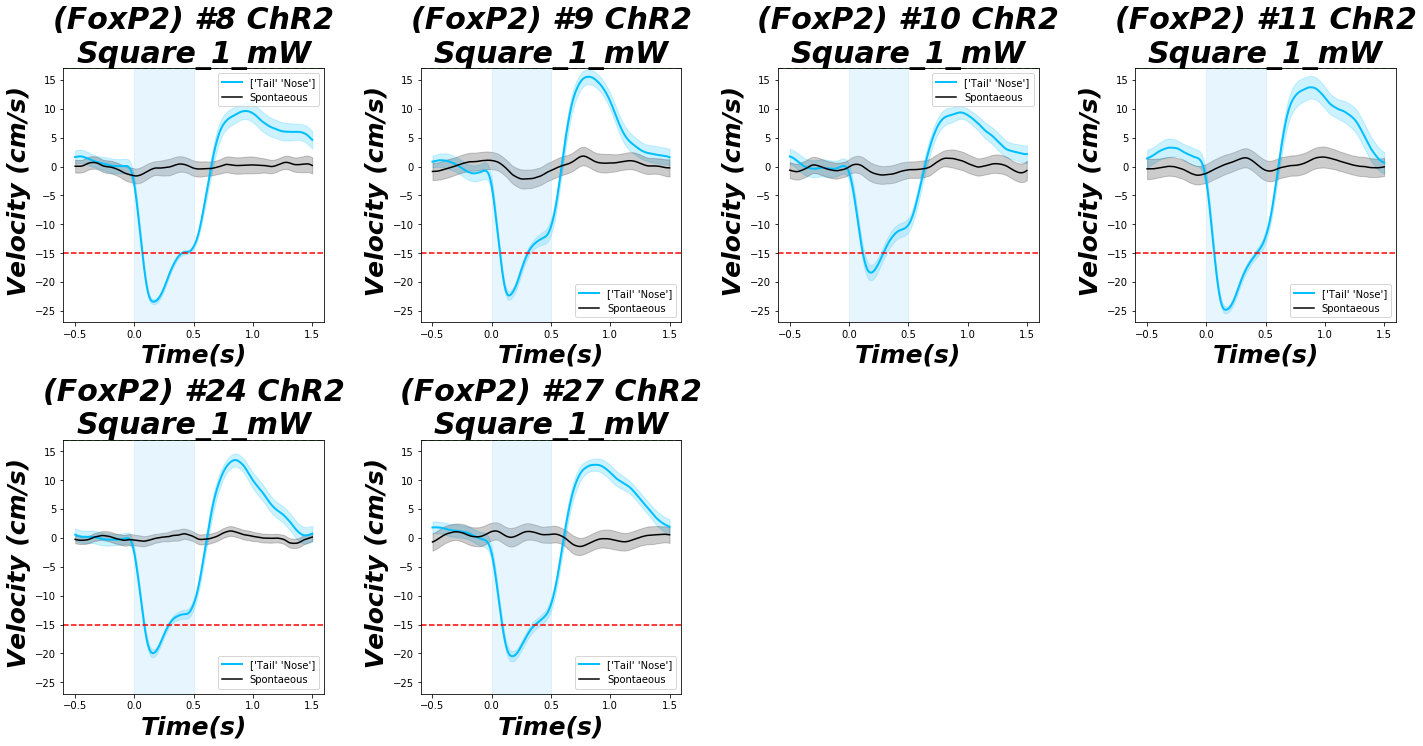

In [39]:
 
where_plot,which_plot, what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

# opto_par_list=['ChR2','Control']
opto_par_list=['ChR2']

# mouse_t_list = ['FoxP2','D2','VGlut']
mouse_t_list = ['FoxP2']


folder = 'Square_1_mW'
# folder = 'GP_15_mW'
# interval = 250# number of timebins of stimulation 

# folder = 'Square_0-5_mW'
for mouse_type in mouse_t_list:  
    
    for opto_par in opto_par_list:
        run_one_intensity_save_data(mouse_type, mouse_no_list[mouse_type],folder,opto_par)



# Plots

## plot the average for all the ChR2 mice

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
1
D2_ChR2_Square_1_mW_mov_aver=10n_t=30.npz
40.76679516775762
FoxP2_ChR2_Square_1_mW_mov_aver=10_n_t=30.npz
47.95160976050347
VGlut_ChR2_Square_1_mW_mov_aver=10n_t=30.npz
53.152521872446776


<Figure size 432x288 with 0 Axes>

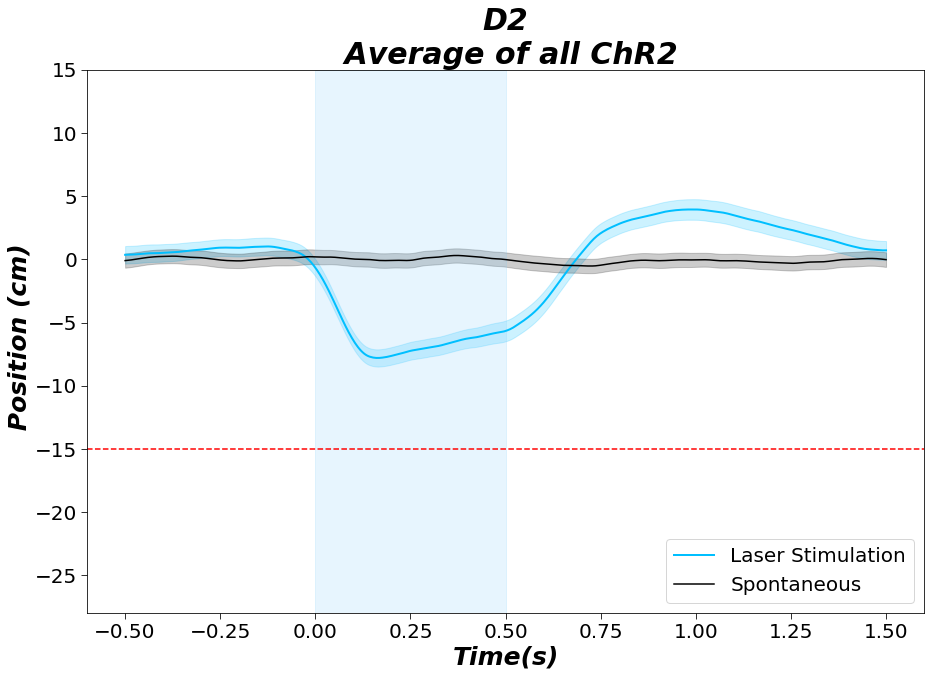

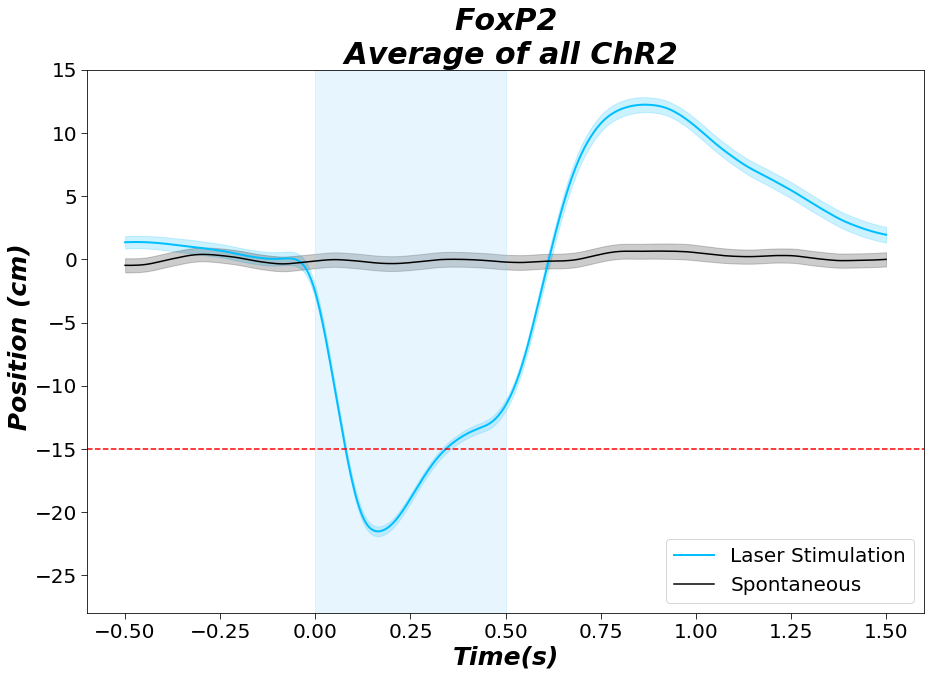

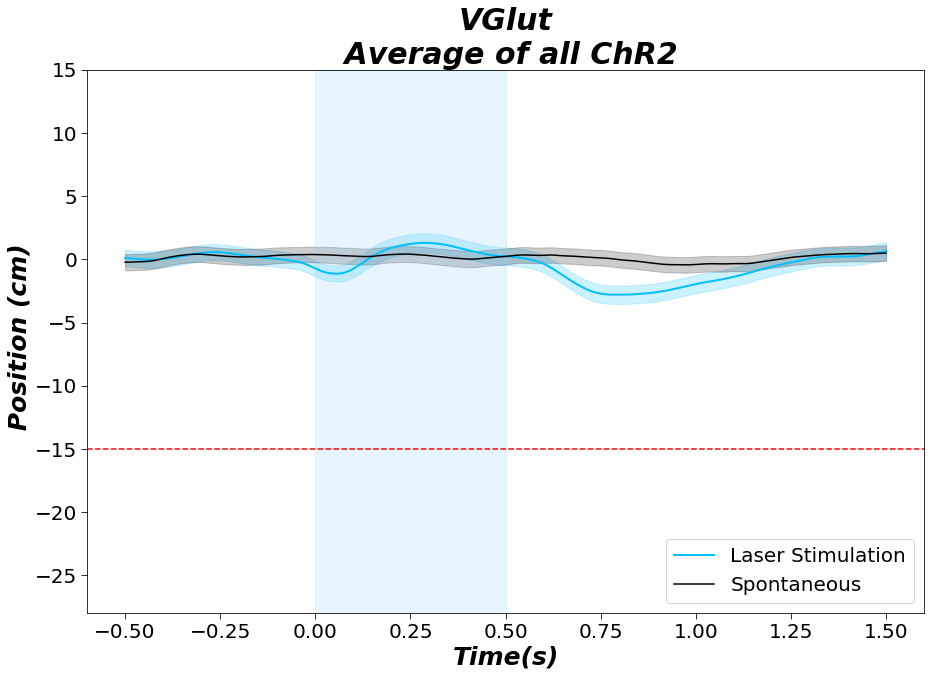

In [41]:
where_plot,which_plot, what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user
folder = 'Square_1_mW'


path =pre_direct+'data_npz/'+folder+'/ChR2/'
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
count = 1
min_y_pre_post = -28 ; max_y_pre_post =  15
for file in Summary_files_list:
    count+=1
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs_all_mice = dat['epochs_all_mice']
    epochs_spont_all_mice = dat['epochs_spont_all_mice']#*scale_pix_to_cm/1000*fps*fps
    print(np.max(epochs_spont_all_mice))
#     epochs_spont_all_mice = np.zeros((epochs_all_mice.shape))
    global mouse_type; global opto_par
    mouse_type = properties[0]
    opto_par = properties[1]
    plt.figure(count)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
    plot_pre_on_post(epochs_all_mice,epochs_spont_all_mice,average = 'Averg_trials_all_mice')


## plot the average for all the Control mice

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
D2_Control_Square_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
FoxP2_Control_Square_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
VGlut_Control_Square_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']


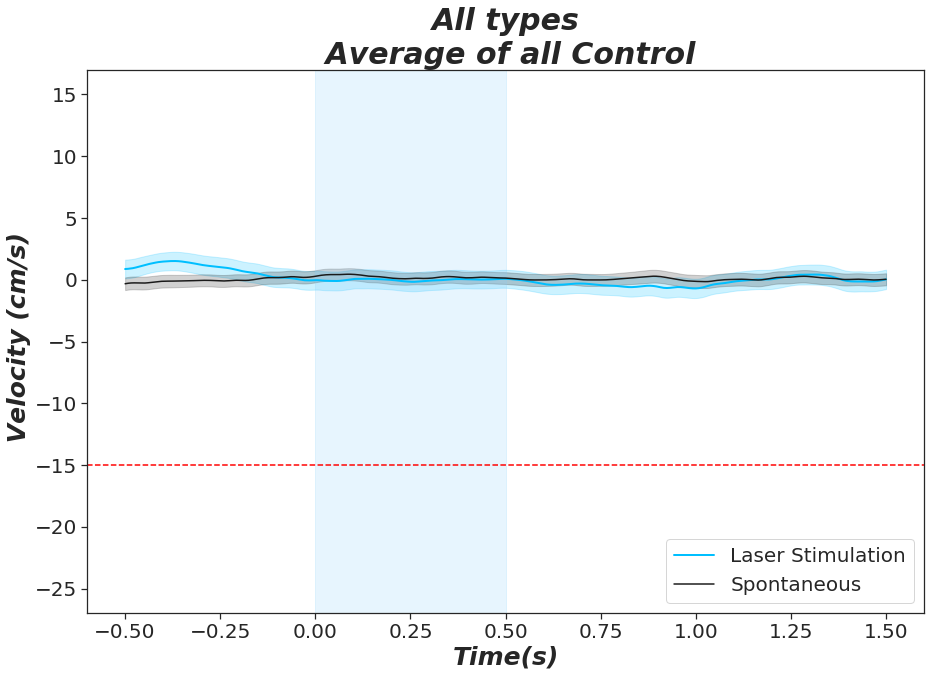

In [232]:
where_plot, which_plot, what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user


folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/Control/'
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
epochs_all_ctr = np.empty((0,pre_interval+interval+post_interval+1))
epochs_spont_all_ctr = np.empty((0,pre_interval+interval+post_interval+1))
count = 0
for file in Summary_files_list:
    count = count+1
    print(file)
    dat = npzfile = np.load(path+file)
    print(dat.files)
    properties=file.split("_")
    epochs_all_ctr = np.append(epochs_all_ctr,dat['epochs_all_mice'], axis = 0)# construct an array of all the trial epochs of all mice
    epochs_spont_all_ctr = np.append(epochs_spont_all_ctr,dat['epochs_spont_all_mice'], axis = 0)# construct an array of all the trial epochs of all mice

#     epochs_spont_all_ctr = np.zeros((epochs_all_ctr.shape))
    global mouse_type; global opto_par
    mouse_type = 'All types'
    opto_par = properties[1]
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)

plot_pre_on_post(epochs_all_ctr,epochs_spont_all_ctr,average = 'Averg_trials_all_mice')

## Look at the relative distance between Hind Limb and Tail in one epoch

# discarded epochs = 0
# discarded epochs = 0


NameError: name 'folder' is not defined

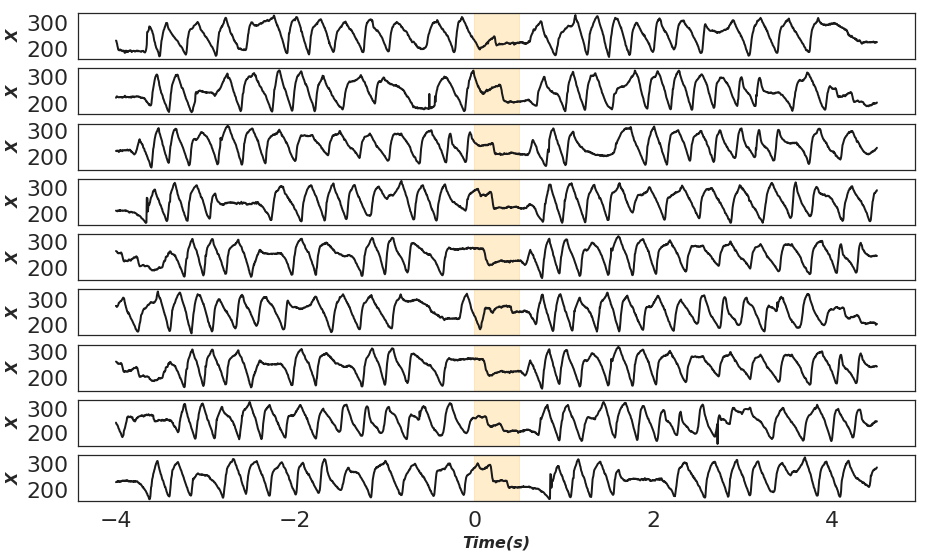

In [18]:
file_name_laser = '/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Square_HI_1/Laser/MouseFoxP2Cre_#8_SquarePulse_1mW_b18_Laser.xlsx' # name of your excel file
file_name_pos ='/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Square_HI_1/DLC/MouseFoxP2Cre_#8_SquarePulse_1mW_b18_DLC.xlsx'

VGlut_list = ([116, 117, 118, 119, 164, 165, 166],[359, 360]) #first list ChR2 second Control
D2_list = ([156, 165, 166, 195, 196, 198, 199],[172, 178])
FoxP2_list = ([8, 9, 10, 11, 27],[23, 26])

pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

# folder = 'Beta_2_mW'
# file_name_laser = '/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Beta_2_mW/Laser/MouseFoxP2Cre_#8_BetaStim_2mW_h01_Laser.xlsx' # name of your excel file
# file_name_pos ='/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Beta_2_mW/DLC/MouseFoxP2Cre_#8_BetaStim_2mW_h01_DLC.xlsx'

between_stim = 250
df = read_DLC(file_name_pos)
laser_t = read_laser(file_name_laser)

time_series  = df.index / fps ## time axis in seconds for stimulation trial
trial_time = max(time_series)
bins  = np.array(laser_t.values).astype(int)
pre_interval = 1000;interval = 125; post_interval = 1000; n =10
epochs_Limb = extract_epochs(bins,df['rFL','x'].values,pre_interval,post_interval,interval)
epochs_Tail = extract_epochs(bins,df['rTail','x'].values,pre_interval,post_interval,interval)
epochs_Limb_rel = epochs_Limb-epochs_Tail
fig = plt.figure(figsize=(15,10))
for i in range(1,n):
    
    x = fig.add_subplot(n,1,i)
    random_num = np.random.randint(0,epochs_Limb_rel.shape[0])
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    plt.plot(time_series, epochs_Limb_rel[random_num,:], color = 'k',linestyle='-',linewidth=2)#, marker='o',markersize=1)
    plt.axvspan(0, interval/fps, alpha=0.2, color='orange')
    plt.ylabel("X", fontproperties=font_label).set_fontproperties(font_label)
    plt.xlabel("Time(s)", fontproperties=font_label).set_fontproperties(font_label)
    
fig.suptitle("Hind Limb X-Position relative to the Tail"+'\n'+"FoxP2Cre "+folder, fontsize =20).set_fontproperties(font)
plt.savefig('/home/shiva/Desktop/Shiva_Behavior/Subplots/Limb_H.pdf',bbox_inches='tight',orientation='landscape',dpi=350)

plt.show()

## Look at a single measure in one session

In [157]:
def extract_epochs_over_trials(files_list,files_list_LED,direct,folder,fp_trial):
    '''return all the epochs of all trials for one mouse '''
    plot_param_list = ['position' , 'velocity', 'acceleration']
    global plot_param
    plot_param = plot_param_list[what_plot]
#     epochs_x = np.empty((0,pre_interval+post_interval+interval+1))
#     epochs_y = np.empty((0,pre_interval+post_interval+interval+1))
    epochs_x = np.empty((0,fp_trial))
    epochs_y = np.empty((0,fp_trial))
    for i in range(0,len(files_list)):
        
        print(' number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = direct+folder+'/DLC/'+files_list[i]
        df = read_DLC_csv(file_path_DLC,fp_trial)
        
        file_path_LED = direct+folder+'/LED/'+files_list_LED[i]
        df_LED = read_LED_csv(file_path_LED)
        if plot_param == 'position':
#             variable = average_position_r_l(df, which_plot,where_plot)
            variable_x = average_position(df, 'x',where_plot,r_or_l,fp_trial)
            variable_y = average_position(df, 'y',where_plot,r_or_l,fp_trial)
        if plot_param == 'velocity':
            variable =  derivative_mov_ave(average_position(df, which_plot,where_plot,r_or_l,fp_trial),n_timebin,window)  # velocity
#             variable = detect_remove_jitter(variable)

#         start = np.arange(0,len(df.index),fp_trial)
#         start = start[:-1]
#         end = start+fp_trial
#         bins  = np.concatenate((start.reshape(-1,1),end.reshape(-1,1)),axis = 1)
#         epochs_trial_x = variable_x[:end[-1]].reshape(len(start),fp_trial)
#         epochs_trial_y = variable_y[:end[-1]].reshape(len(start),fp_trial)
        epochs_trial_x = variable_x.reshape(int(len(variable_x)/fp_trial),fp_trial)
        epochs_trial_y = variable_y.reshape(int(len(variable_y)/fp_trial),fp_trial)

#         epochs_trial = extract_epochs(bins,variable,pre_interval,post_interval,interval)
        epochs_x = np.append(epochs_x,epochs_trial_x,axis = 0)
        epochs_y = np.append(epochs_y,epochs_trial_y,axis = 0)

#     if plot_param == 'position':
#         return epochs- np.repeat(epochs[:,0].reshape(epochs.shape[0],1),epochs.shape[1],axis = 1)
#     else:
    return epochs_x,epochs_y
    
def correct_labeling_jitter(x, jitter_threshold, n_iter,t_s,fp_trial):
    ''' correct the detections exceeding the max speed of the mouse with
        the average of before and after time stamps 
        '''
    xx = x.copy()
    xx = xx.reshape(int(len(xx)/fp_trial),fp_trial)
    for i in range(n_iter):
        shifted = np.roll(xx, 1, axis=1) # np.roll shifts in a periodic manner, hence the next line
        shifted[:,0] = shifted[:,1] # set the shifted value 
        deltas = xx -  shifted
        ind_row,ind_col = np.where(np.absolute(deltas) > jitter_threshold)
        filter_ = np.logical_and((ind_col > t_s+1) , (ind_col < xx.shape[1]-t_s-1)) # discard the beginning and the end
        ind_col = ind_col[filter_]
        ind_row = ind_row[filter_]
        ind = np.vstack((ind_row,ind_col)).T # tuples of indices
        if len(ind_row) > 0: # if jumped in detection set to the mean of <t_s> previous and next detections
            xx[ind_row,ind_col] = np.hstack([np.average(xx[i,j-t_s:j-1])+np.average(xx[i,j+1:j+t_s]) for i,j in ind])/2
            print("# jitter in DLC  = ", len(ind_row))                                     
#     print("nan found? How many? ",sum(np.isnan(x)))
#     print(x[ind])
    
    return xx.flatten().reshape(-1,1)


def average_position(df,cor,where_plot,r_or_l,fp_trial):
    ''' average over the selected body parts '''
    
    body_part_list = body_part[where_plot]
    averaged_position = np.zeros((len(df.index),1))
    for param in body_part_list : # average over body parts
        x = np.copy(df[(r_or_l+param,cor)].values).reshape(-1,1)
        averaged_position += correct_labeling_jitter(x,jitter_threshold,n_iter_jitter, t_s,fp_trial)
#         averaged_position += x
    averaged_position = averaged_position/len(body_part_list)
    return   averaged_position#moving_average_array(averaged_position, window)
 
def run_one_intensity_save_data(rat_no, day_list):
    ''' run data over all mice of one group and one intensity and 
    save data of epochs and individal mice to a npz file'''
#     epochs_spont_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
#     epochs_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
#     epochs_mean_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
# #     epochs_min_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
    plt.figure(2)
    fig = plt.figure(figsize=(20,15))
    nrows=2;ncols=3
#     fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=True)

    count = 0
    for day in day_list: # Run over all the mice
        print(day)
        count +=1
        start = timeit.default_timer()
        folder = day
        direct = pre_direct +"/Rat_"+str(rat_no)+'/'  # directory to the folder for each mouse
#         print(direct+folder)
        files_list_DLC = list_all_files(direct+folder+'/DLC',extension)
        files_list_LED = list_all_files(direct+folder+'/LED',extension)

        if len(files_list_DLC)==0 :
            print("No files for ",day)
            continue
#         elif len(files_list_LED)==0 :
#             print("No Laser detection for mouse # ",n)
#             continue
        else:
            epochs_x, epochs_y = extract_epochs_over_trials(files_list_DLC,files_list_LED,direct,folder,fp_trial)

            ax = fig.add_subplot(nrows,ncols,count)
#             ax = axes[int(count/ncols),count%nrows]
            plot_trajectory(epochs_x,epochs_y,day)
            stop = timeit.default_timer()
            print('run time = ',stop-start)

    plt.tight_layout()

    # fig.suptitle(cor+ "-Velocity ("+mouse_type+") "+opto_par+"\n"+" interval = "+ str(n_timebin) , fontproperties=font)
    plt.savefig(pre_direct+'/Subplots'+'/All_days_'+'Rat_'+str(rat_no)+'.png',bbox_inches='tight',orientation='landscape',dpi=200)
    plt.show()

#     file_name = mouse_type+'_'+opto_par+'_'+folder+"_mov_aver="+str(window)+"_n_t="+str(n_timebin)
#     np.savez( os.path.join(pre_direct+'data_npz/'+folder+'/'+opto_par, file_name),
#              epochs_all_mice=epochs_all_mice,
#              epochs_mean_each_mouse=epochs_mean_each_mouse, epochs_spont_all_mice=epochs_spont_all_mice)

#     save_npz(mouse_type,opto_par,folder,folder, window,n_timebin,"",
#              epochs_all_mice, epochs_mean_each_mouse, epochs_spont_all_mice)
def plot_trajectory(epochs_x,epochs_y,day):
    epochs_mean_x = np.average(epochs_x, axis = 0)
    epochs_mean_y = np.average(epochs_y, axis = 0)
    rand_epochs = np.random.randint(0,epochs_x.shape[0],50)
    for j in rand_epochs:

        plt.plot(epochs_x[j],epochs_y[j], color = 'lightskyblue', linestyle='-',linewidth=1, alpha=.5)#, marker='o',markersize=1)
    #     plt.plot(np.arange(len(epochs_x[j])),epochs_x[j], color = 'lightskyblue', linestyle='-',linewidth=2, alpha=.8, marker='o',markersize=1)
    #     plt.scatter(np.arange(len(epochs_x[j])),epochs_x[j], color = 'lightskyblue')

    plt.plot(epochs_mean_x,epochs_mean_y, color = 'k', linestyle='-',linewidth=3, alpha=1,label = "mean trajectory")#, marker='o',markersize=1)
    plt.title("Rat #"+str(rat_no)+"\n"+day).set_fontproperties(font)
    plt.ylabel("Y cm").set_fontproperties(font_label)
    plt.ylabel("X cm").set_fontproperties(font_label)
    plt.xlim(1,6)
    plt.ylim(1.5,5.5)

/home/shiva/Desktop/Sophie/DLC/Rat_12/Day_8
Rat 12 head 1 6OHDA x2 12-06-19_20190612_095920_C001H001S0001DLC_resnet50_Rat_lever_Sophie_02Mar28shuffle1_1000000.csv
Select for which parts you want to see the trial: 

 1. finger 0 
 2. finger 1 joint 
 3. finger 1 base 
 4. finger 2 joint 
 5. finger 2 base
1
 1. Position 
 2. Velocity 
 
1
Day_-1
 number of session = 1 out of 4
# jitter in DLC  =  2005
# jitter in DLC  =  1915
 number of session = 2 out of 4
# jitter in DLC  =  1870
# jitter in DLC  =  1830
 number of session = 3 out of 4
# jitter in DLC  =  1708
# jitter in DLC  =  1619
 number of session = 4 out of 4
# jitter in DLC  =  1861
# jitter in DLC  =  1759
run time =  0.41299317000084557
Day_0
 number of session = 1 out of 4
# jitter in DLC  =  2699
# jitter in DLC  =  2710
 number of session = 2 out of 4
# jitter in DLC  =  3294
# jitter in DLC  =  3318
 number of session = 3 out of 4
# jitter in DLC  =  1597
# jitter in DLC  =  1588
 number of session = 4 out of 4
# jitter 

<Figure size 432x288 with 0 Axes>

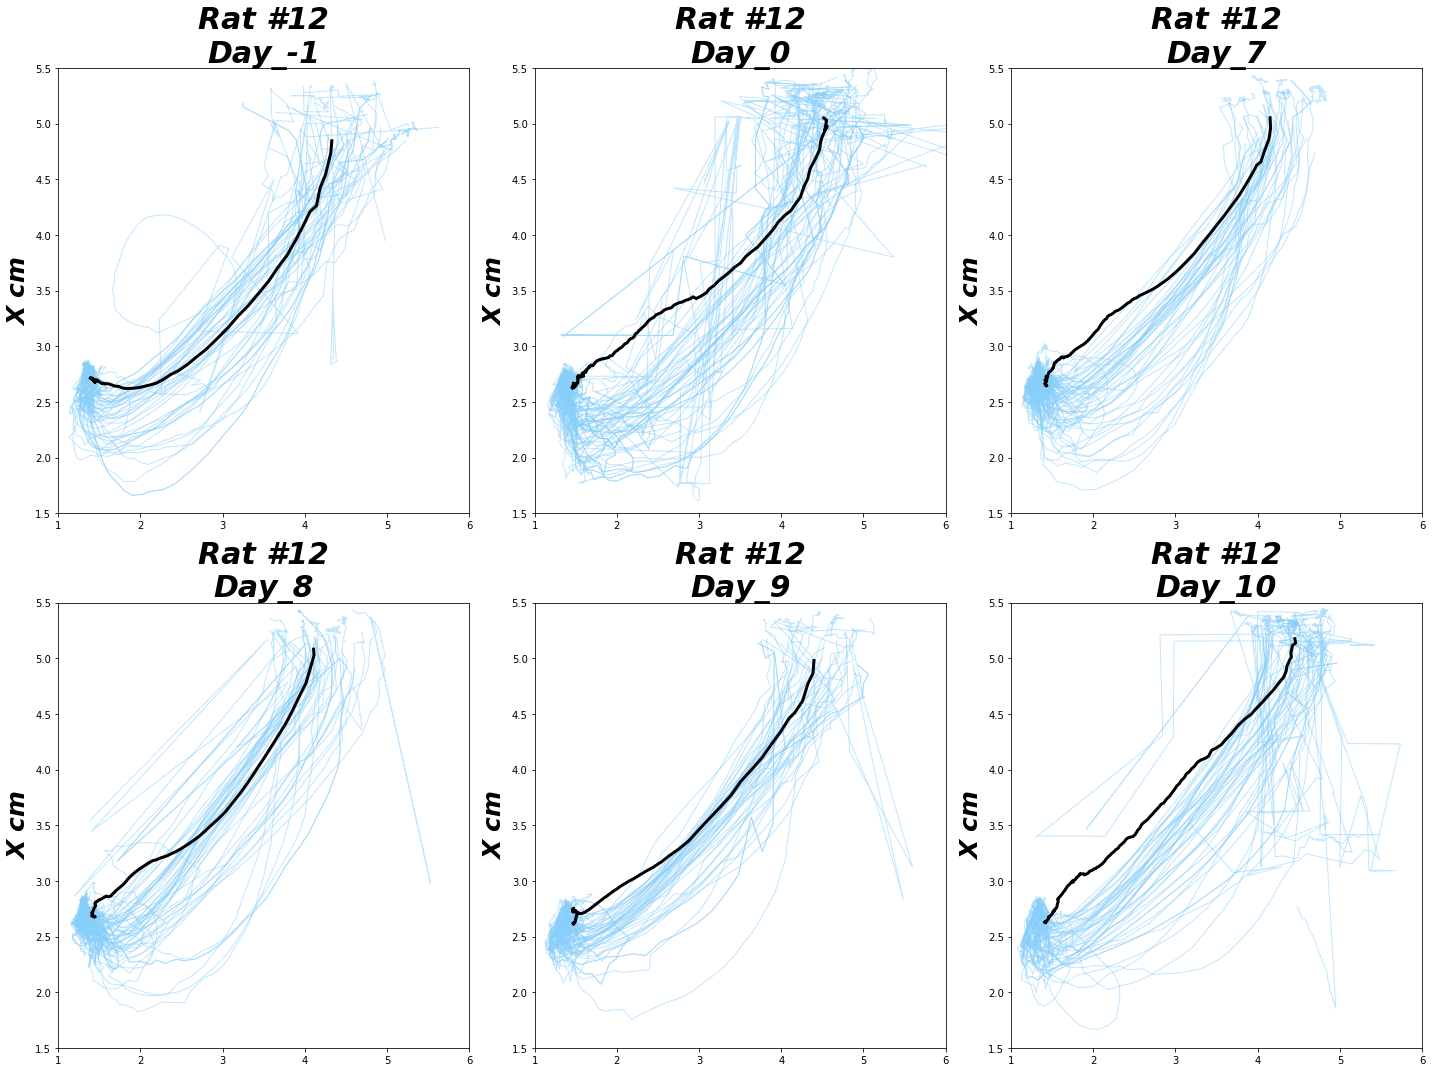

In [158]:
fp_trial = 375 # number of frames per trial
np.random.seed(10)
r_or_l = 'L' # right or left hand
rat_no = 12; spont = "n"; folder = "Day_8"
day_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
direct = pre_direct +'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
print(direct+folder)
extension = ".csv"
files_list_DLC = list_all_files(direct+folder+'/DLC','.csv')
files_list_LED = list_all_files(direct+folder+'/LED','.csv')
n_iter = 1
t_s = 3
jitter_threshold = 3/fps
i = 2 # which session to look
print(files_list_DLC[i])
df = read_DLC_csv(direct+folder+'/DLC/'+files_list_DLC[i],fp_trial)
# df_LED = read_LED_csv(direct+folder+'/LED/'+files_list_LED[i])
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)

# plt.scatter(df.index,df['Lfinger0','y'])
# plt.xlim(14200,14300)
where_plot,what_plot = get_input_cor_body_part() # decide to average over what and coordinates

# epochs_x, epochs_y = extract_epochs_over_trials(files_list_DLC,files_list_LED,direct,folder,fp_trial)

#     ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
#     ax.xaxis.set_ticks_position('bottom')
#     ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
#     ax.yaxis.set_ticks_position('left')


# plt.show()
run_one_intensity_save_data(rat_no, day_list)

In [83]:
rand_epochs

array([100])

In [56]:
a = np.arange(10)
b = np.arange(100)
def hey(a,b):
    b = a+3
hey(a,b)
print(b)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


## Naive Implementation of X-V distinction

In [13]:

def categorize_x_v_and_save(mouse_type, folder, opto_par,pre_interval,post_interval,interval,pre_stim_inter,back_front_boundary ):
    
    if pre_interval > pre_stim_inter:
        pre_era = pre_interval
    else:
        pre_era = pre_stim_inter
        
    
    epochs_all_mice = np.empty((0,pre_interval+interval+post_interval+1))

    # epochs_spont_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
    # epochs_mean_each_mouse_pos = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
    # epochs_mean_each_mouse_neg = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice

    epochs_all_mice_pos_front = np.empty((0,pre_interval+interval+post_interval+1))
    epochs_all_mice_neg_front = np.empty((0,pre_interval+interval+post_interval+1))

    epochs_mean_each_mouse_pos_front = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
    epochs_mean_each_mouse_neg_front = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice

    epochs_all_mice_pos_back = np.empty((0,pre_interval+interval+post_interval+1))
    epochs_all_mice_neg_back = np.empty((0,pre_interval+interval+post_interval+1))

    epochs_mean_each_mouse_pos_back = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
    epochs_mean_each_mouse_neg_back = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice

    epochs_min_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice

    fig = plt.figure(figsize=(20,15))
    outer = gridspec.GridSpec(3, 4, wspace=0.2, hspace=0.2)
    if opto_par == "Control":
        loop_list = mouse_no_list[mouse_type][1]
    else:
        loop_list = mouse_no_list[mouse_type][0]
        
    count = 0
    for n in loop_list: # Run over all the mice
        count +=1
        start = timeit.default_timer()
        mouse_no = n
        print(n)
        direct = pre_direct + mouse_type +'/'+ opto_par + '/Mouse_' + str(mouse_no)+ '/'  # directory to the folder for each mouse
        files_list_DLC = list_all_files(direct+folder+'/DLC',extension)
        files_list_Laser = list_all_files(direct+folder+'/Laser',extension)
        if len(files_list_DLC)==0 :
            print("No files for mouse # ",n)
            continue
        elif len(files_list_Laser)==0 :
            print("No Laser detection for mouse # ",n)
            continue
        else:
            epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,'n',pre_era,post_interval,interval) 
            if pre_era > pre_interval:
                epochs_all_mice = np.append(epochs_all_mice, epochs[:,pre_stim_inter-pre_interval:], axis = 0)# construct an array of all the trial epochs of all mice
                pre_vel = np.average(epochs[:,:pre_stim_inter],axis = 1)
            else:
                epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
                pre_vel = np.average(epochs[:,pre_interval - pre_stim_inter:pre_era],axis = 1)
            epochs_spont = np.zeros(np.shape(epochs))

            ## distiction by acceleration at laser onset
            what_plot = 1 # for velocity


            ind_negative_accel, = np.where(pre_vel < 0)
            ind_positive_accel, = np.where(pre_vel > 0)

            print("#positive accel={}".format(len(ind_positive_accel)))
            print("#negative accel={}".format(len(ind_negative_accel)))


        #     inner = gridspec.GridSpecFromSubplotSpec(1, 2,
        #                     subplot_spec=outer[count-1], wspace=0.1, hspace=0.1)
        #     ax = plt.Subplot(fig, inner[0])
        #     fig.add_subplot(ax)
        #     plot_pre_on_post(epochs[ind_negative_accel,:],epochs_spont,average = 'Averg_trials')
        #     plt.title(mouse_type+" #"+str(mouse_no) +"\n"+" interval = "+ str(n_timebin)+" a>0" , fontsize=10)
        #     plt.ylim(-10,8)

            ## distiction by x position at laser onset
            what_plot = 0 # for velocity
            pre_x_position_epochs = extract_pre_laser_x_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder, pre_stim_inter)
            pre_x_position = np.average(pre_x_position_epochs[:,:pre_stim_inter],axis = 1)
            ind_back_x, = np.where(pre_x_position > back_front_boundary)
            ind_front_x, = np.where(pre_x_position < back_front_boundary)

            print("#front={}".format(len(ind_front_x)))
            print("#back={}".format(len(ind_back_x)))

        #     plot_pre_on_post(epochs[ind_back_x,:],epochs_spont,average = 'Averg_trials')
        #     plt.title(mouse_type+" #"+str(mouse_no) +"\n"+"at back #trials= " +str(len(ind_back_x)), fontsize=10)
        #     ax.get_legend().remove()
        #     plt.ylabel("")
        #     plt.ylim(-12,12)
        #     x = fig.add_subplot(3,4,count)
        #     epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,spont ='n') 
        # #     epochs_spont = extract_epochs_over_trials(files_list_spont,files_list_Laser,direct,folder_spont,spont ='y')
            ########################################## To save data with acceleration distinction
        #     epochs_all_mice_pos = np.append(epochs_all_mice_pos, epochs[ind_positive_accel,:], axis = 0)# construct an array of all the trial epochs of all mice
        #     epochs_all_mice_neg = np.append(epochs_all_mice_neg,epochs[ind_negative_accel,:], axis = 0)# construct an array of all the trial epochs of all mice
        # #     epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs

        #     temp = min_and_mean_on_off(epochs[ind_positive_accel,:],pre_interval,post_interval,interval,'Mean')
        #     average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
        #     epochs_mean_each_mouse_pos = np.append(epochs_mean_each_mouse_pos,average_of_on_off_on,axis = 0)
        #     temp = min_and_mean_on_off(epochs[ind_negative_accel,:],pre_interval,post_interval,interval,'Mean')
        #     average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
        #     epochs_mean_each_mouse_neg = np.append(epochs_mean_each_mouse_neg,average_of_on_off_on,axis = 0)

            #############################################
            epochs_all_mice_pos_front = np.append(epochs_all_mice_pos_front, epochs[np.intersect1d(ind_positive_accel,ind_front_x),:], axis = 0)# construct an array of all the trial epochs of all mice
            epochs_all_mice_neg_front = np.append(epochs_all_mice_neg_front,epochs[np.intersect1d(ind_negative_accel,ind_front_x),:], axis = 0)# construct an array of all the trial epochs of all mice
            print(np.max(epochs[np.intersect1d(ind_negative_accel,ind_front_x),:pre_stim_inter]))
            temp = min_and_mean_on_off(epochs[np.intersect1d(ind_positive_accel,ind_front_x),:],pre_interval,post_interval,interval,'Mean')
            average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
            epochs_mean_each_mouse_pos_front = np.append(epochs_mean_each_mouse_pos_front,average_of_on_off_on
                                               ,axis = 0)
            temp = min_and_mean_on_off(epochs[np.intersect1d(ind_negative_accel,ind_front_x),:],pre_interval,post_interval,interval,'Mean')
            average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
            epochs_mean_each_mouse_neg_front = np.append(epochs_mean_each_mouse_neg_front,average_of_on_off_on
                                               ,axis = 0)
            ## Back
            epochs_all_mice_pos_back = np.append(epochs_all_mice_pos_back, epochs[np.intersect1d(ind_positive_accel,ind_back_x),:], axis = 0)# construct an array of all the trial epochs of all mice
            epochs_all_mice_neg_back = np.append(epochs_all_mice_neg_back,epochs[np.intersect1d(ind_negative_accel,ind_back_x),:], axis = 0)# construct an array of all the trial epochs of all mice

            temp = min_and_mean_on_off(epochs[np.intersect1d(ind_positive_accel,ind_back_x),:],pre_interval,post_interval,interval,'Mean')
            average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
            epochs_mean_each_mouse_pos_back = np.append(epochs_mean_each_mouse_pos_back,average_of_on_off_on,axis = 0)
            temp = min_and_mean_on_off(epochs[np.intersect1d(ind_negative_accel,ind_back_x),:],pre_interval,post_interval,interval,'Mean')
            average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
            epochs_mean_each_mouse_neg_back = np.append(epochs_mean_each_mouse_neg_back,average_of_on_off_on,axis = 0)
            stop = timeit.default_timer()
            print('run time = ',stop-start)
            #############################################

        #     ax = plt.Subplot(fig, inner[1])
        #     fig.add_subplot(ax)
        #     plot_pre_on_post(epochs[ind_positive_accel,:],epochs_spont,average = 'Averg_trials')
        #     plt.title(mouse_type+" #"+str(mouse_no) +"\n"+" interval = "+ str(n_timebin)+" a<0" , fontsize=10)
        # #     plot_pre_on_post(epochs[ind_front_x,:],epochs_spont,average = 'Averg_trials')
        # #     plt.title(mouse_type+" #"+str(mouse_no) +"\n"+"in front #trials= " +str(len(ind_front_x)) , fontsize=10)
        #     ax.get_legend().remove()
        #     plt.ylabel("")
        #     plt.ylim(-10,8)

    # plt.suptitle('D2 Cre '+'\n'+'intensity='+intensity+' mW'+'pre stim window='+str(pre_stim_inter),fontsize= 30,y = 1)
    # plt.tight_layout()
    # plt.savefig(pre_direct+'Subplots'+'/Pre_laser_accel_distinction_'+opto_par+'_'+mouse_type+'_' +
    #             '.png',bbox_inches='tight',orientation='landscape',dpi=400)
    # # plt.savefig(pre_direct+'Subplots'+'/Pre_laser_x_distinction_'+opto_par+'_'+mouse_type+'_' +
    # #             '.png',bbox_inches='tight',orientation='landscape',dpi=400)
    # plt.show()

    file_name_ext = "_Square_1_mW_pos_front_"+folder
    save_npz(mouse_type,opto_par,"Distinction", folder, window,n_timebin,file_name_ext,
                 epochs_all_mice_pos_front, epochs_mean_each_mouse_pos_front, [])

    file_name_ext = "_Square_1_mW_pos_back_"+folder
    save_npz(mouse_type,opto_par,"Distinction", folder,window,n_timebin,file_name_ext,
                 epochs_all_mice_pos_back, epochs_mean_each_mouse_pos_back, [])

    file_name_ext = "_Square_1_mW_neg_front_"+folder
    save_npz(mouse_type,opto_par,"Distinction", folder, window,n_timebin,file_name_ext,
                 epochs_all_mice_neg_front, epochs_mean_each_mouse_neg_front, [])

    file_name_ext = "_Square_1_mW_neg_back_"+folder
    save_npz(mouse_type,opto_par,"Distinction",folder, window,n_timebin,file_name_ext,
                 epochs_all_mice_neg_back, epochs_mean_each_mouse_neg_back, [])
    
    
where_plot,which_plot, what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

min_x =200; max_y = 25 ; max_x = 200
elec_shock = 3 # electro shock section of the treadmil cm
back_front_boundary = (treadmill_len-elec_shock)/3 # set the limit below which is considered back of the treadmill
pre_stim_inter = 125 # number of timebins in the pre-stimulus period 
# n_bins = 45

extension = '.xlsx'
opto_par = 'ChR2'
# opto_par = 'Control'
folder = 'GP_15_mW';
# folder = 'Square_1_mW'
# folder = 'STN+GP_1_mW';

mouse_type = 'VGlut'
# mouse_type = 'D2';
# mouse_type = ['FoxP2']

categorize_x_v_and_save(mouse_type, folder, opto_par,pre_interval,post_interval,interval,pre_stim_inter,back_front_boundary )

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
116
spont =n
 number of session = 1 out of 3
# inconsistent right left =  59
# jitter in mean(righ,left)  =  3582
# inconsistent right left =  8925
# jitter in mean(righ,left)  =  6506
# discarded epochs = 2
 number of session = 2 out of 3
# inconsistent right left =  15
# jitter in mean(righ,left)  =  3003
# inconsistent right left =  1607
# jitter in mean(righ,left)  =  3653
# discarded epochs = 0
 number of session = 3 out of 3
# inconsistent right left =  17
# jitter in mean(righ,left)  =  3956
# inconsistent right left =  1178
# jitter in mean(righ,left)  =  3033
# discarded epochs = 0
#positive accel=46
#negative accel=40
x number of session = 1 out of 3
# inconsistent right left =  59
# jitter in mean(righ,left)  =  3582
# inconsistent right left =  8925
# jitter in mean(righ,left)  =  6506
# x discarded epochs = 2
x numbe

# inconsistent right left =  1
# jitter in mean(righ,left)  =  1934
# inconsistent right left =  69
# jitter in mean(righ,left)  =  672
# x discarded epochs = 32
x number of session = 5 out of 6
# inconsistent right left =  4
# jitter in mean(righ,left)  =  3825
# inconsistent right left =  284
# jitter in mean(righ,left)  =  512
# x discarded epochs = 18
x number of session = 6 out of 6
# inconsistent right left =  2
# jitter in mean(righ,left)  =  2184
# inconsistent right left =  314
# jitter in mean(righ,left)  =  521
# x discarded epochs = 20
#front=155
#back=2
23.612262840833807
run time =  83.14863510000032
165
spont =n
 number of session = 1 out of 6
# inconsistent right left =  8
# jitter in mean(righ,left)  =  4092
# inconsistent right left =  2676
# jitter in mean(righ,left)  =  3837
# discarded epochs = 0
 number of session = 2 out of 6
# inconsistent right left =  4
# jitter in mean(righ,left)  =  2366
# inconsistent right left =  2604
# jitter in mean(righ,left)  =  2507


<Figure size 1440x1080 with 0 Axes>

GP_15_mW VGlut
VGlut_ChR2_GP_15_mW_Square_1_mW_neg_back_GP_15_mW_mov_aver=10_n_t=30.npz
VGlut_ChR2_GP_15_mW_Square_1_mW_neg_front_GP_15_mW_mov_aver=10_n_t=30.npz
VGlut_ChR2_GP_15_mW_Square_1_mW_pos_back_GP_15_mW_mov_aver=10_n_t=30.npz
VGlut_ChR2_GP_15_mW_Square_1_mW_pos_front_GP_15_mW_mov_aver=10_n_t=30.npz
VGlut_ChR2_GP_15_mW_pre_x_pre_v_mov_aver=10_n_t=30.npz
   mean_velocity mouse_type optogenetic expression pulse_type intensity_mW  \
0      -1.062173      VGlut                   ChR2     Square            1   
1      -1.346132      VGlut                   ChR2     Square            1   
2     -11.737425      VGlut                   ChR2     Square            1   
3      -4.222736      VGlut                   ChR2     Square            1   
4      -9.636012      VGlut                   ChR2     Square            1   

  epoch velocity     x  
0   OFF      neg  back  
1   OFF      neg  back  
2   OFF      neg  back  
3   OFF      neg  back  
4   OFF      neg  back  


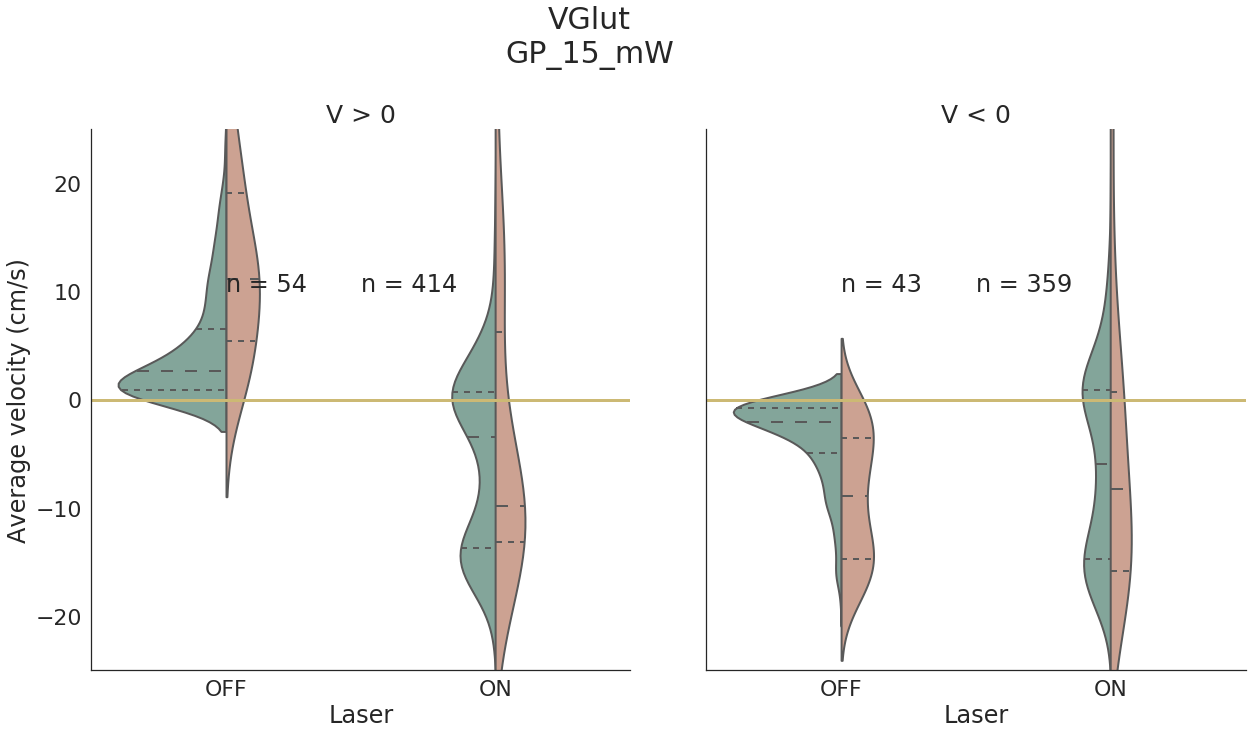

In [21]:
mouse_type = 'VGlut'
# mouse_type = 'D2';
# mouse_type = 'FoxP2'

folder = "GP_15_mW"
# folder = 'STN+GP_1_mW'; 
# folder = 'STN'; 

print(folder,mouse_type)
path =pre_direct+'data_npz/Distinction/ChR2/'+mouse_type+'/GP/'
extension = ".npz"

Summary_files_list = list_all_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch','velocity']
result = pd.DataFrame(columns = col_names)
stringlist = []
for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    stringlist.append('n = '+str(epochs.shape[0]))
    ### set the variables of epoch/optogen/pulse type/mouse type/velocity and x of pre stim
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[5]] * epochs.shape[0]*2
    Velocity_ = [properties[8]]* epochs.shape[0]*2
    x_ = [properties[9]]* epochs.shape[0]*2
    inten_ = [properties[6]] * epochs.shape[0]*2
    try:
        off_vel = np.average(pre,axis = 1)
        on_vel = np.average(post,axis = 1)
        all_ = np.concatenate((off_vel,on_vel),axis = 0)
    except ZeroDivisionError:
        all_ = np.empty((0))
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    # append the data of each mouse to a unit dataframe
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_,'velocity':Velocity_,'x':x_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
print(result.head())

sns.set_style("white")
g = sns.catplot(x="epoch", y="mean_velocity",
                hue="x", col="velocity",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                 scale_hue=False, linewidth = 2, inner="quartile", scale = 'area',
                hue_order=['front','back'],col_order=['pos','neg'],legend = False)

result_pos = result[result['velocity'] == 'pos']
result_neg = result[result['velocity'] == 'neg']
ax1, ax2 = g.axes[0]
# sns.swarmplot(x="epoch", y="mean_velocity",ax = ax1,
#                 hue="x",
#                 data=result_pos, color="r", edgecolor="g", size = 6,
#                 hue_order=['front','back'])

# sns.swarmplot(x="epoch", y="mean_velocity",ax = ax2,
#                 hue="x",
#                 data=result_neg, color="r", edgecolor="g", size = 6,
#                 hue_order=['front','back'])


x_series = [0.3,0.6]
xposlist = [ 0, 0.5]
for i in range(0,2):
    ax2.text(xposlist[i], 10, stringlist[i])
    
for i in range(2,4):
    ax1.text(xposlist[i-2], 10, stringlist[i])
## plot the data of each mice together with the violin plot
# for i in range (epochs_mean_mouse_pos.shape[0]):
#     ax1.plot(x_series,epochs_mean_mouse_pos[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
#     ax1.plot(x_series,np.average(epochs_mean_mouse_pos[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

# for i in range (epochs_mean_mouse_neg.shape[0]):
#     ax2.plot(x_series,epochs_mean_mouse_neg[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
#     ax2.plot(x_series,np.average(epochs_mean_mouse_neg[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)


sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-25,25])

ax1.axhline( y=0, ls='-', c='y',linewidth = 3)
ax2.axhline( y=0, ls='-', c='y',linewidth = 3)

ax1.set_title('V > 0', y=0.95, fontsize = 25)
ax2.set_title('V < 0', y=0.95, fontsize = 25)

g.set_axis_labels("Laser", "Average velocity (cm/s)")
plt.suptitle(mouse_type+'\n'+folder,fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
# legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
# legend = plt.legend(loc='upper right', title='position on treadmill',fontsize= 20)

# plt.savefig(path+'X_V_distinction_'+folder+'.png',bbox_inches='tight',orientation='landscape',dpi=350)



## Categorize trials by pre-laser X/V and Plot by distinction

In [151]:
folder = 'Square_0-5_mW'
# folder = 'Square_1_mW'
# folder = 'Square_0-25_mW'
# folder = 'GP_15_mW';
# folder = 'STN+GP_1_mW';

VGlut_list = ([ 164, 165, 166],[359, 360]) #first list ChR2 second Control
mouse_no_list = pd.DataFrame(({'D2':D2_list, 'VGlut':VGlut_list, 'FoxP2':FoxP2_list}))

opto_par = 'ChR2'
# mouse_type = 'D2';
mouse_type = 'VGlut'
# mouse_type = 'FoxP2'
pre_interval = 125
pre_stim_inter = pre_interval
average_pre_x_v_and_save(mouse_type, folder, opto_par,pre_interval,post_interval,interval,pre_stim_inter)


Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
# mouse =  164
spont =n
 number of session = 1 out of 3
# inconsistent right left =  0
# jitter in mean(righ,left)  =  117
# inconsistent right left =  0
# jitter in mean(righ,left)  =  27
# discarded epochs = 0
 number of session = 2 out of 3
# inconsistent right left =  0
# jitter in mean(righ,left)  =  97
# inconsistent right left =  0
# jitter in mean(righ,left)  =  21
# discarded epochs = 0
 number of session = 3 out of 3
# inconsistent right left =  0
# jitter in mean(righ,left)  =  318
# inconsistent right left =  0
# jitter in mean(righ,left)  =  121
# discarded epochs = 0
x number of session = 1 out of 3
# inconsistent right left =  0
# jitter in mean(righ,left)  =  117
# inconsistent right left =  0
# jitter in mean(righ,left)  =  27
# x discarded epochs = 0
x number of session = 2 out of 3
# inconsistent right left =  

VGlut_ChR2_Square_0-5_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30.npz
[1.465044385318841, 2.919722189877011]


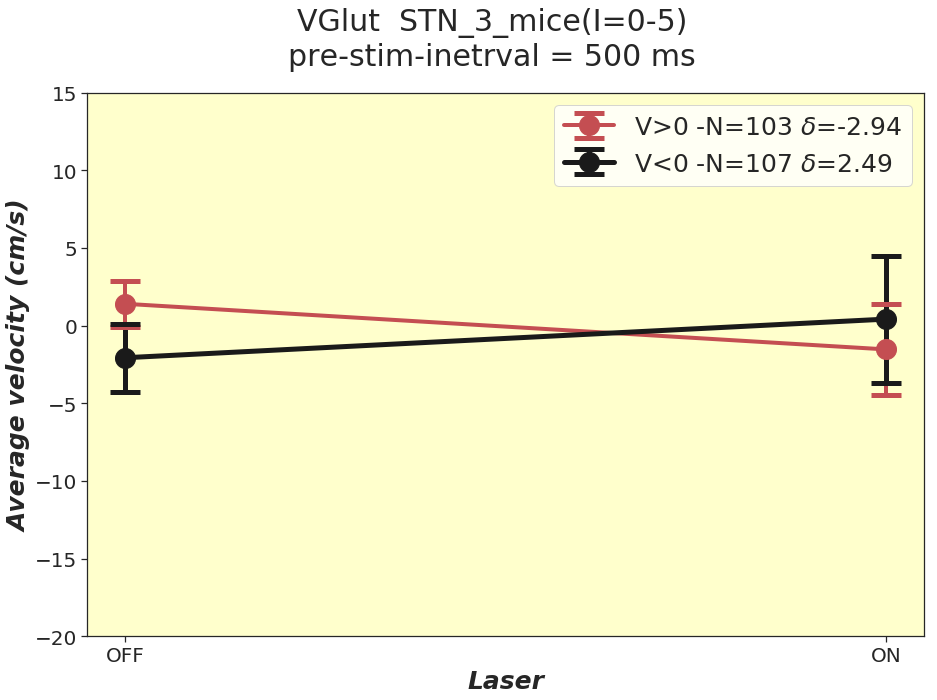

In [152]:
# mouse_type = 'D2';
# folder = 'STR'; 

# mouse_type = 'FoxP2'
# folder = "GP"

mouse_type = 'VGlut'
# folder = 'STN+GP'; 
folder = 'STN_3_mice'; 
# folder = 'GP'; 


path =pre_direct+'data_npz/Distinction/ChR2/'+mouse_type+'/'+folder+"/"

result_val = read_npz_return_data_frame(path,pre_interval,post_interval,interval)
result = categorize_pre_x_and_v(result_val,back_front_boundary,0)
violin_plot_X_V_distiction(result, path, mouse_type, folder, pre_stim_inter)
plot_phase_space_V(result,path,mouse_type,folder,pre_stim_inter)
Plot_ON_OFF_X_V_mean(result,path,mouse_type,folder,pre_stim_inter)
Plot_ON_OFF_V_mean(result,path,mouse_type,folder,pre_stim_inter)

## Look at the results of different intensity on FoxP2

FoxP2_ChR2_Beta_0-5_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse']
FoxP2_ChR2_Beta_1_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse']
FoxP2_ChR2_Beta_2_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'FoxP2_ChR2_Beta_5_mW_mov_aver.npz']
FoxP2_ChR2_Beta_5_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse']
FoxP2_Control_Beta_5_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse']


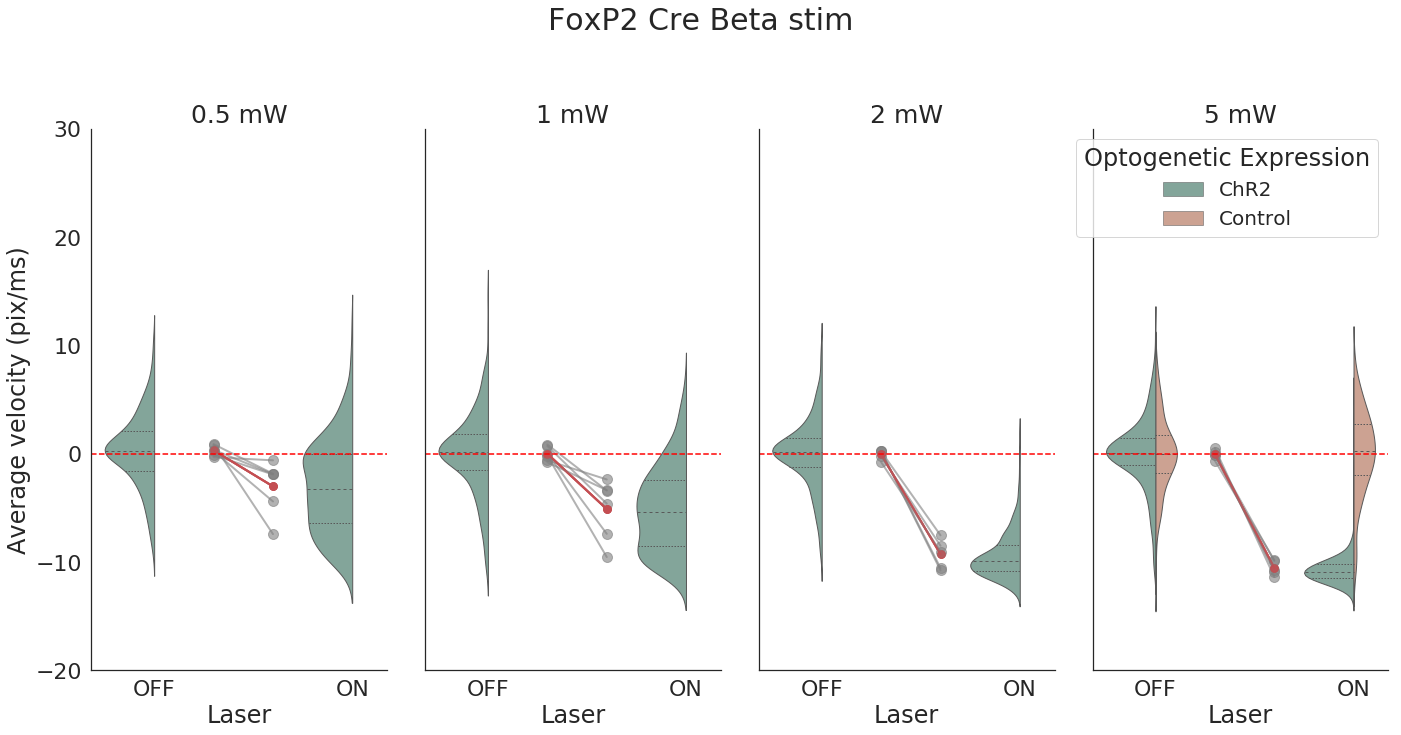

In [19]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

path = "/Users/apple/Desktop/data_npz/"
path =pre_direct+'data_npz/BetaStim/'
extension = ".npz"
Summary_files_list = list_all_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)



for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    print(dat.files)
    ## data for individual plot points of mice
    if properties[3]=='0-5' and properties[1] != 'Control':
        epochs_mean_mouse_0_5 = dat[dat.files[1]]
        min_arg_0_25 = np.argmin(epochs[:,pre_interval+1:pre_interval+interval+1], axis = 1)
    if properties[3]=='1'and properties[1] != 'Control':
        epochs_mean_mouse_1 = dat[dat.files[1]]
    if properties[3]=='2'and properties[1] != 'Control':
        epochs_mean_mouse_2 = dat[dat.files[1]]
    if properties[3]=='5'and properties[1] != 'Control':
        epochs_mean_mouse_5 = dat[dat.files[1]]

    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[3]] * epochs.shape[0]*2
  
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
# print(result.head())

import seaborn as sns

# g = sns.FacetGrid(result, col="mouse_type", size=5, aspect=1.5)
sns.set_style("white")
# path = "/Users/apple/Desktop/data_npz/"

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", col="intensity_mW",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile", scale = 'count',
                hue_order=['ChR2','Control'],col_order=['0-5','1','2', '5'],legend = False,width=.5)
x_series = [0.3,0.6]
ax1, ax2, ax3, ax4 = g.axes[0]
for i in range (epochs_mean_mouse_0_5.shape[0]):
    ax1.plot(x_series,epochs_mean_mouse_0_5[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax1.plot(x_series,np.average(epochs_mean_mouse_0_5[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_1.shape[0]):
    ax2.plot(x_series,epochs_mean_mouse_1[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax2.plot(x_series,np.average(epochs_mean_mouse_1[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_2.shape[0]):
    ax3.plot(x_series,epochs_mean_mouse_2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax3.plot(x_series,np.average(epochs_mean_mouse_2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
for i in range (epochs_mean_mouse_5.shape[0]):
    ax4.plot(x_series,epochs_mean_mouse_5[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax4.plot(x_series,np.average(epochs_mean_mouse_5[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-20,30])
ax1, ax2, ax3 , ax4= g.axes[0]
ax1.axhline( y=0, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red')
ax3.axhline( y=0, ls='--', c='red')
ax4.axhline( y=0, ls='--', c='red')
ax1.set_title('0.5 mW', y=0.95, fontsize = 25)
ax2.set_title('1 mW', y=0.95, fontsize = 25)
ax3.set_title('2 mW', y=0.95, fontsize = 25)
ax4.set_title('5 mW', y=0.95, fontsize = 25)

g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle('FoxP2 Cre Beta stim',fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(path+'All_Beta_FoxP2.pdf',bbox_inches='tight',orientation='landscape',dpi=350)



# Compare STN STN+G GP

VGlut_ChR2_GP_15_mW_mov_aver=10_n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
VGlut_ChR2_STN+GP_1_mW_mov_aver=10_n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
VGlut_ChR2_STN_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OFFSTN_ChR2 v.s. ONSTN_ChR2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.539e-02 U_stat=2.832e+05
OFFSTN+GP_ChR2 v.s. ONSTN+GP_ChR2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.413e-15 U_stat=8.648e+05
OFFGP_ChR2 v.s. ONGP_ChR2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.399e-48 U_stat=5.321e+05


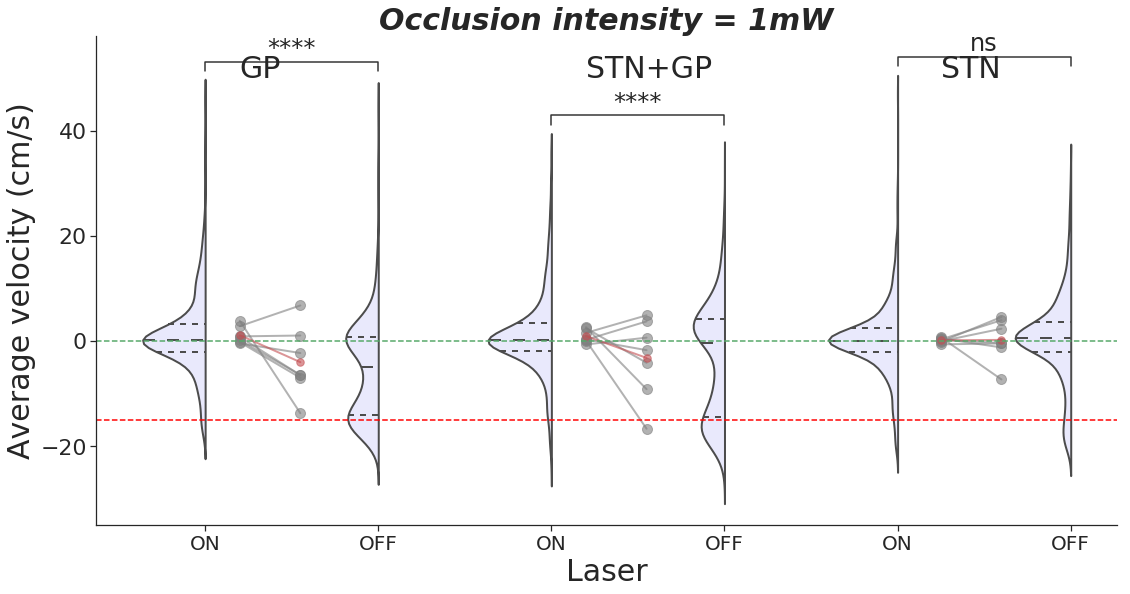

In [10]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

# path = "/Users/apple/Desktop/data_npz/"
path =pre_direct+'data_npz/Occlusion/'
extension = ".npz"
Summary_files_list = list_all_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type','optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)



for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    print(dat.files)
    ## data for individual plot points of mice
    if properties[2]=='GP' and properties[1] != 'Control':
        epochs_mean_mouse_GP = dat[dat.files[1]]
        min_arg_0_25 = np.argmin(epochs[:,pre_interval+1:pre_interval+interval+1], axis = 1)
    if properties[2]=='STN'and properties[1] != 'Control':
        epochs_mean_mouse_STN = dat[dat.files[1]]
    if properties[2]=='STN+GP'and properties[1] != 'Control':
        epochs_mean_mouse_STN_GP = dat[dat.files[1]]

    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[3]] * epochs.shape[0]*2
  
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
#     epoch_off = ['OFF'] * epochs.shape[0]
#     epoch_on = ['ON'] * epochs.shape[0]
    epoch_off = ['OFF'+properties[2]] * epochs.shape[0]
    epoch_on = ['ON'+properties[2]] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
# print(result.head())

import seaborn as sns

# g = sns.FacetGrid(result, col="mouse_type", size=5, aspect=1.5)
sns.set_style("white")

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression",
                data=result, kind="violin", color = 'blue',

                height=5, scale_hue=False, linewidth = 2, inner="quartile",split=True,scale ='area', 
                box_pairs=[(("ONSTN","ChR2"), ("OFFSTN","ChR2")), (("ONSTN+GP","ChR2"), ("OFFSTN+GP","ChR2"))
                               , (("ONGP","ChR2"), ("OFFGP","ChR2"))],
                hue_order=['ChR2','Control'],legend = False, gridsize = 100)

axes = g.axes.flatten()


add_stat_annotation(axes[0], data=result,x="epoch", y="mean_velocity",hue="optogenetic expression",
                    box_pairs=[(("ONSTN","ChR2"), ("OFFSTN","ChR2")), (("ONSTN+GP","ChR2"), ("OFFSTN+GP","ChR2"))
                               , (("ONGP","ChR2"), ("OFFGP","ChR2"))],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)

x_series = [0.2,0.55]
plt.text(min(x_series), 50, 'GP', fontsize=30)
for i in range (epochs_mean_mouse_GP.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_GP[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
plt.plot(x_series,np.average(epochs_mean_mouse_GP[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

x_series = [2.2,2.55]
plt.text(min(x_series), 50, 'STN+GP', fontsize=30)
for i in range (epochs_mean_mouse_STN_GP.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_STN_GP[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
plt.plot(x_series,np.average(epochs_mean_mouse_STN_GP[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

x_series = [4.25,4.6]
plt.text(min(x_series), 50, 'STN', fontsize=30)
for i in range (epochs_mean_mouse_STN.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_STN[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
plt.plot(x_series,np.average(epochs_mean_mouse_STN[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-35,58])



plt.axhline( y=0, ls='--', c='g')
plt.axhline( y=treadmil_velocity, ls='--', c='red')


axes[0].set_xlabel("laser",fontsize=30)
axes[0].set_ylabel("Average velocity (cm/s)",fontsize=30)
axes[0].get_xaxis().set_tick_params(direction='out')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].get_yaxis().set_tick_params(direction='out')
axes[0].yaxis.set_ticks_position('left')

axes[0].set_xticklabels(['ON','OFF', 'ON','OFF', 'ON','OFF'],fontsize = 20)
g.set_axis_labels("Laser", "Average velocity (cm/s)")
# plt.suptitle('Occlusion 1 mW',fontsize= 30,y = 1)
plt.title("Occlusion"+" intensity = "+properties[3]+"mW").set_fontproperties(font)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)
# legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(path+'All_Occlusion.png',bbox_inches='tight',orientation='landscape',dpi=350)



# In the next cells we look at the violin plots of all the data for different intensities

## Intensity = 1 mW without control

D2_ChR2_Square_1_mW_mov_aver=10n_t=30.npz
WilcoxonResult(statistic=46940.0, pvalue=6.562310128487223e-56)
(748, 501)
FoxP2_ChR2_Square_1_mW_mov_aver=10n_t=30.npz
WilcoxonResult(statistic=1847.0, pvalue=1.0622827257659725e-114)
(711, 501)
VGlut_ChR2_Square_1_mW_mov_aver=10n_t=30.npz
WilcoxonResult(statistic=145085.0, pvalue=0.30511411246641906)
(778, 501)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
OFFD2_ChR2 v.s. OND2_ChR2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.969e-55 stat=4.694e+04
Using zero_method  wilcox
OFFVGlut_ChR2 v.s. ONVGlut_ChR2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=9.153e-01 stat=1.451e+05
Using zero_method  wilcox
OFFFoxP2_ChR2 v.s. ONFoxP2_ChR2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.187e-114 stat=1.847e+03


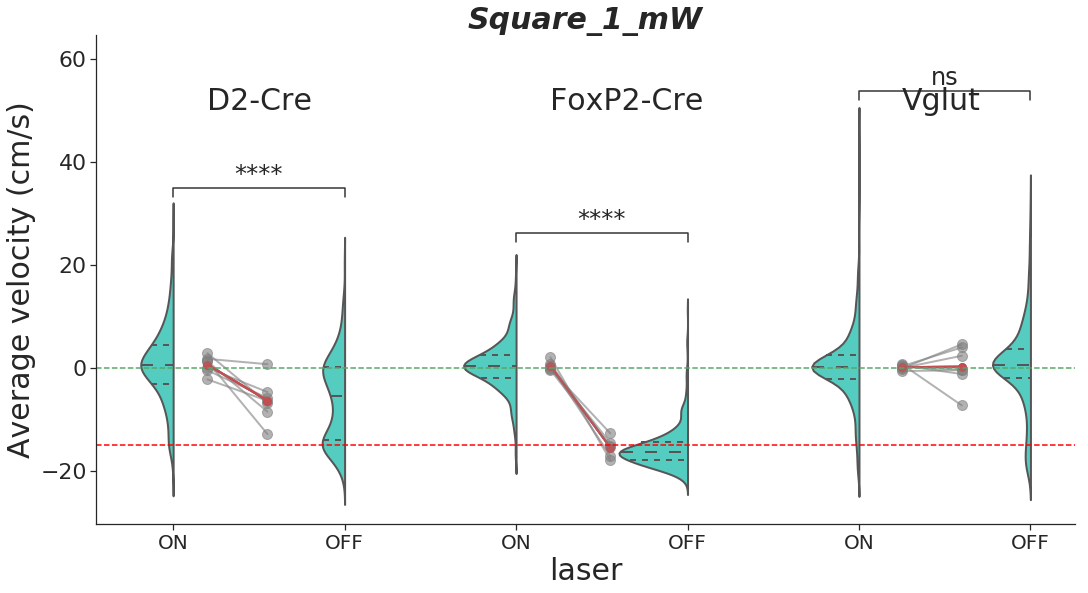

In [13]:

# path = "/Users/apple/Desktop/data_npz/"
folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/ChR2/'
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)

# direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse


for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='VGlut' and properties[1] != 'Control':
        epochs_mean_mouse_Vglut = dat[dat.files[1]]
    if properties[0]=='D2'and properties[1] != 'Control':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2'and properties[1] != 'Control':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
    inten_ = [properties[3]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    stat_result = stats.mannwhitneyu(off_vel, on_vel, use_continuity=True, alternative='two-sided')
    
    stat_result = stats.wilcoxon(off_vel, on_vel, alternative='two-sided')
    print(stat_result)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'+properties[0]] * epochs.shape[0]
    epoch_on = ['ON'+properties[0]] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    print(epochs.shape)
    
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
result.head()

import seaborn as sns
sns.set(font_scale = 2)
sns.set_style("white")

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", 
                data=result, kind="violin",  palette= ['turquoise'],
                height=5,  scale_hue=False,linewidth = 2, inner="quartile",split=True,scale ='area',
                hue_order=['ChR2','Control'],legend = False, gridsize = 100 )
ax1 = g.axes[0]
axes = g.axes.flatten()
add_stat_annotation(axes[0], data=result,x="epoch", y="mean_velocity",hue="optogenetic expression",
                    box_pairs=[(("OND2","ChR2"), ("OFFD2","ChR2")), (("ONVGlut","ChR2"), ("OFFVGlut","ChR2"))
                               , (("ONFoxP2","ChR2"), ("OFFFoxP2","ChR2"))],
                    test='Wilcoxon', text_format='star', loc='inside', verbose=2)
x_series = [0.2,0.55]

plt.text(min(x_series), 50, 'D2-Cre', fontsize=30)
for i in range (epochs_mean_mouse_D2.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
x_series = [4.25,4.6]
plt.text(min(x_series), 50, 'Vglut', fontsize=30)
for i in range (epochs_mean_mouse_Vglut.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_Vglut[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_Vglut[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
x_series = [2.2,2.55]
plt.text(min(x_series), 50, 'FoxP2-Cre', fontsize=30)
for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    
    plt.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)


plt.axhline( y=0, ls='--', c='g')
plt.axhline( y=treadmil_velocity, ls='--', c='red')

axes[0].set_xlabel("laser",fontsize=30)
axes[0].set_ylabel("Average velocity (cm/s)",fontsize=30)
axes[0].get_xaxis().set_tick_params(direction='out')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].get_yaxis().set_tick_params(direction='out')
axes[0].yaxis.set_ticks_position('left')

axes[0].set_xticklabels(['ON','OFF', 'ON','OFF', 'ON','OFF'],fontsize = 20)
plt.title(folder).set_fontproperties(font)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)
# legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(path+folder+'_ChR2.pdf',bbox_inches='tight',orientation='landscape',dpi=500)



## MWW_test 

In [12]:
MWW_test(result,result_Ctr,"D2")
MWW_test(result,result_Ctr,"FoxP2")
MWW_test(result,result_Ctr,"VGlut")

MWW ChR2 vs. Ctr D2 =  MannwhitneyuResult(statistic=49169.0, pvalue=3.4797233276772544e-22)
MWW ChR2 vs. Ctr FoxP2 =  MannwhitneyuResult(statistic=4773.0, pvalue=5.105197551040777e-100)
MWW ChR2 vs. Ctr VGlut =  MannwhitneyuResult(statistic=58132.0, pvalue=0.1412577148316645)


MannwhitneyuResult(statistic=58132.0, pvalue=0.1412577148316645)

## Intensity = 1  mW Control

D2_Control_Square_1_mW_mov_aver=10n_t=30.npz
(227, 501)
FoxP2_Control_Square_1_mW_mov_aver=10n_t=30.npz
(223, 501)
VGlut_Control_Square_1_mW_mov_aver=10n_t=30.npz
(158, 501)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OFF_Control v.s. ON_Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.993e-02 U_stat=1.949e+05
(2, 3)


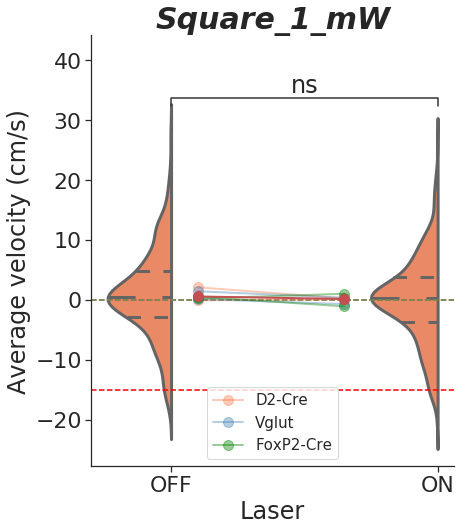

In [8]:

# path = "/Users/apple/Desktop/data_npz/"
folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/Control/'
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result_Ctr = pd.DataFrame(columns = col_names)

# direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse


for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='VGlut':
        epochs_mean_mouse_Vglut = dat[dat.files[1]]
    if properties[0]=='D2':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
    inten_ = [properties[3]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    print(epochs.shape)
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result_Ctr, df]
    result_Ctr = pd.concat(frames,ignore_index=True)
result_Ctr.head()

import seaborn as sns
sns.set(font_scale = 2)

sns.set_style("white")


g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", 
                data=result_Ctr, kind="violin",  palette= ['coral'],
                height=4,  scale_hue=False,linewidth = 3, inner="quartile",split=True,scale ='area',width = 0.5,
                hue_order=['Control','ChR2'],legend = False, label='_nolegend_')
axes = g.axes.flatten()
add_stat_annotation(axes[0], data=result_Ctr,x="epoch", y="mean_velocity",hue="optogenetic expression",
                    box_pairs=[(("ON","Control"), ("OFF","Control"))],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.axhline( y=0, ls='--', c='red')

x_series = [0.1,0.65]

plt.axhline( y=0, ls='--', c='g')
plt.axhline( y=treadmil_velocity, ls='--', c='red')

# plt.text(min(x_series), 30, 'D2-Cre', fontsize=22)
for i in range (epochs_mean_mouse_D2.shape[0]):
    plt1, = plt.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'coral',marker = 'o',markersize=10,linewidth=2,alpha=0.4)
# plt1,=plt.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'.-',
#              color = 'darkorange',marker = '.',markersize=15,linewidth=3,alpha=1, label = 'D2-Cre')

for i in range (epochs_mean_mouse_Vglut.shape[0]):
    plt2, = plt.plot(x_series,epochs_mean_mouse_Vglut[i,:2],'-',color = 'steelblue',marker = 'o',markersize=10,linewidth=2,alpha=0.4)
# plt2,=plt.plot(x_series,np.average(epochs_mean_mouse_Vglut[:,:2],axis =0),'.-'
#              ,color = 'darkblue',marker = '.',markersize=15,linewidth=3,alpha=1, label ='Vglut')

for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    plt3, = plt.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'green',marker = 'o',markersize=10,linewidth=2,alpha=0.4)
# plt3,=plt.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'.-'
#              ,color = 'darkgreen',marker = '.',markersize=15,linewidth=3,alpha=1,label = 'FoxP2-Cre')

mean_mean = (np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0)+np.average(epochs_mean_mouse_Vglut[:,:2])+
               np.average(epochs_mean_mouse_D2[:,:2],axis =0))/3
             
plt4, = plt.plot(x_series,mean_mean,'-',color = 'r',marker = 'o',markersize=10,linewidth=2,alpha=1)

g.set_axis_labels("Laser", "Average velocity (cm/s)")

axes[0].get_xaxis().set_tick_params(direction='out')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].get_yaxis().set_tick_params(direction='out')
axes[0].yaxis.set_ticks_position('left')

plt.title(folder).set_fontproperties(font)
g.fig.set_figwidth(10.0)
g.fig.set_figheight(10)
plt.legend(handles=[plt1,plt2,plt3],labels=['D2-Cre','Vglut','FoxP2-Cre'],loc = 'lower center',fontsize =15)
plt.savefig(path+folder+'_Control.pdf',bbox_inches='tight',orientation='landscape',dpi=500)
print(epochs_mean_mouse_Vglut.shape)

## intensity = 1mW with Control

D2_ChR2_Square_HI_1_mov_aver.npz
(748, 501)
D2_Control_Square_HI_1.npz
(228, 501)
FoxP2_ChR2_Square_HI_1_mov_aver.npz
(711, 501)
FoxP2_Control_Square_HI_1.npz
(223, 501)
Vglut_ChR2_Square_HI_1_mov_aver.npz
(778, 501)
Vglut_Control_Square_HI_1.npz
(158, 501)


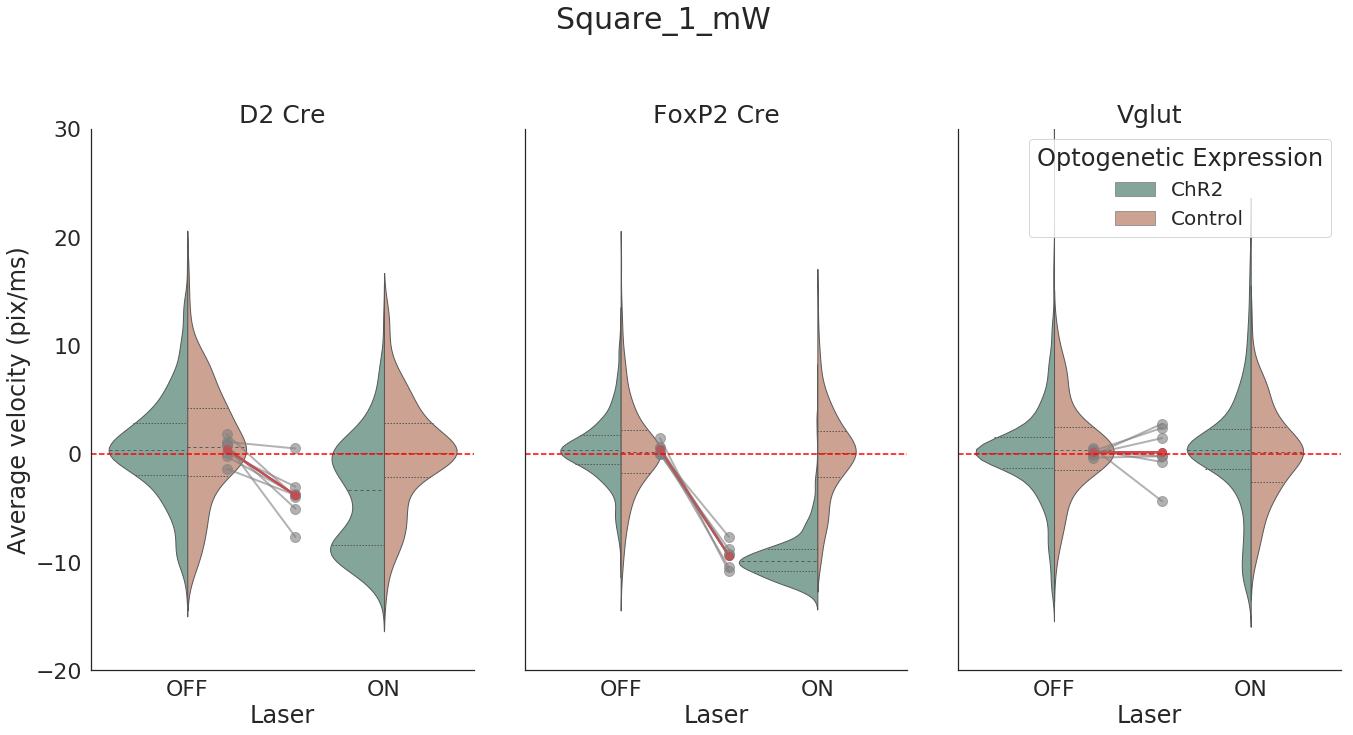

In [16]:

# path = "/Users/apple/Desktop/data_npz/"
folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/'
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)

# direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse


for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='Vglut' and properties[1] != 'Control':
        epochs_mean_mouse_Vglut = dat[dat.files[1]]
    if properties[0]=='D2'and properties[1] != 'Control':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2'and properties[1] != 'Control':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[4]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    print(epochs.shape)
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
result.head()

import seaborn as sns

sns.set_style("white")

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", col="mouse_type",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile", scale = 'area',
                hue_order=['ChR2','Control'],col_order=['D2','FoxP2','Vglut'],legend = False)
x_series = [0.2,0.55]
ax1, ax2, ax3 = g.axes[0]
for i in range (epochs_mean_mouse_Vglut.shape[0]):
    ax3.plot(x_series,epochs_mean_mouse_Vglut[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax3.plot(x_series,np.average(epochs_mean_mouse_Vglut[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_D2.shape[0]):
    ax1.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax1.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    ax2.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax2.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-20,30])
# plt.xlim([-2,2])
ax1, ax2, ax3 = g.axes[0]
ax1.axhline( y=0, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red')
ax3.axhline( y=0, ls='--', c='red')
ax1.set_title('D2 Cre', y=0.95, fontsize = 25)
ax2.set_title('FoxP2 Cre', y=0.95, fontsize = 25)
ax3.set_title('Vglut', y=0.95, fontsize = 25)
g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle(folder,fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(path+folder+'.pdf',bbox_inches='tight',orientation='landscape',dpi=350)



## Intensity = 0.5 mW

D2_ChR2_Beta_0-5_mW_mov_aver.npz
D2_Control_Beta_0-5_mW_mov_aver.npz
FoxP2_ChR2_Beta_0-5_mW_mov_aver.npz
FoxP2_Control_Beta_0-5_mW_mov_aver.npz
VGlut_ChR2_Beta_0-5_mW_mov_aver.npz
VGlut_Control_Beta_0-5_mW_mov_aver.npz


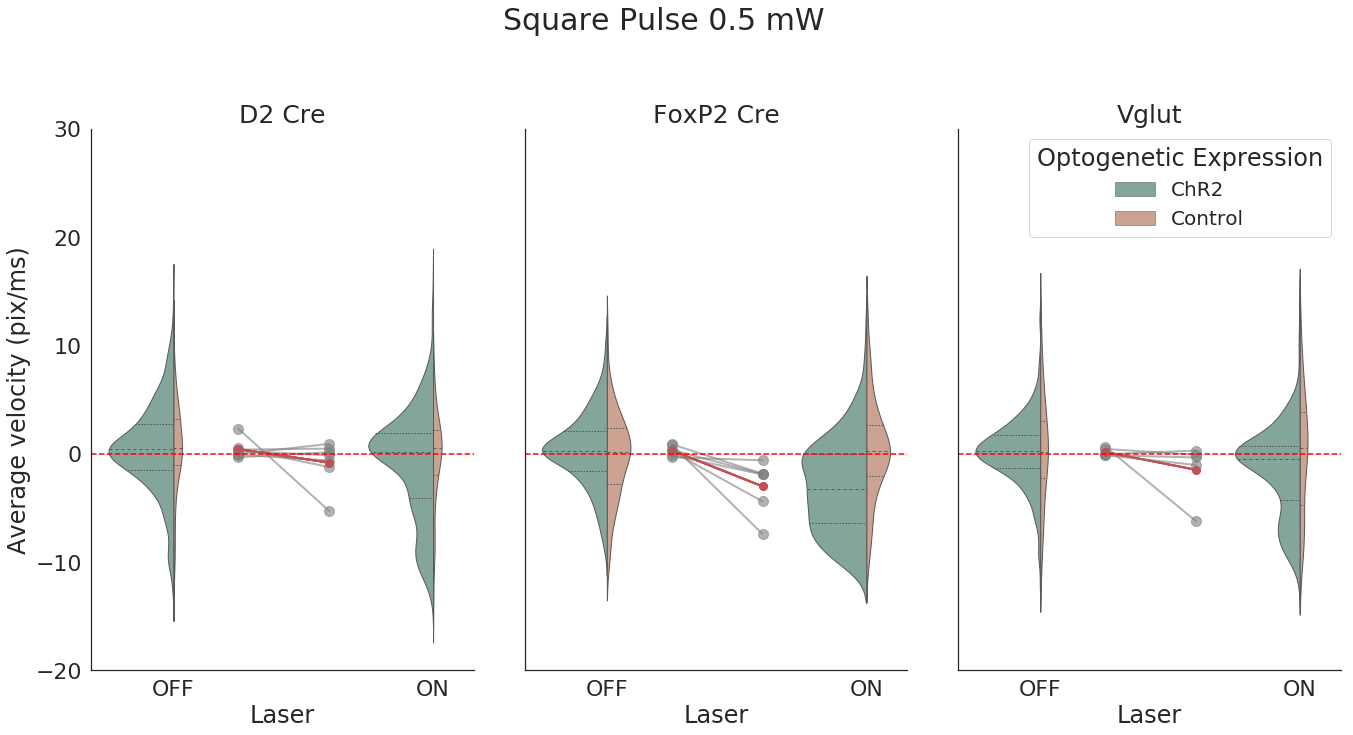

In [65]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

# path = "/Users/apple/Desktop/data_npz_mov_avg/"
path = pre_direct+'data_npz/BetaStim/0-5_mW/'
extension = ".npz"
Summary_files_list = list_all_data_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)



for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='VGlut' and properties[1] != 'Control':
        epochs_mean_mouse_Vglut = dat[dat.files[1]]
    if properties[0]=='D2'and properties[1] != 'Control':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2'and properties[1] != 'Control':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
    
    inten_ = [properties[3]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
    
# print(result.head())
# plt.rcParams["axes.labelsize"] = 15
sns.set(font_scale = 2)
sns.set_style("white")
g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", col="mouse_type",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile",scale='count',
                hue_order=['ChR2','Control'],col_order=['D2','FoxP2','VGlut'],legend=False,width=.5)


x_series = [0.25,0.6]
ax1, ax2, ax3 = g.axes[0]
for i in range (epochs_mean_mouse_Vglut.shape[0]):
    ax3.plot(x_series,epochs_mean_mouse_Vglut[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax3.plot(x_series,np.average(epochs_mean_mouse_Vglut[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_D2.shape[0]):
    ax1.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax1.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    ax2.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax2.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

# set(xlim=(0,2),ylim=(-20,30))
plt.ylim([-20,30])
ax1.axhline( y=0, ls='--', c='red');#ax1.axhline( y=-15, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red');#ax1.axhline( y=-15, ls='--', c='red')
ax3.axhline( y=0, ls='--', c='red');#ax1.axhline( y=-15, ls='--', c='red')
ax1.set_title('D2 Cre', y=0.95, fontsize = 25)
ax2.set_title('FoxP2 Cre', y=0.95, fontsize = 25)
ax3.set_title('Vglut', y=0.95, fontsize = 25)
g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle('Beta Stim 0.5 mW',fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(path+'plot_mov_avg_0-5_mW.png',bbox_inches='tight',orientation='landscape',dpi=350)

# legend.get_title().set_fontsize('15') 

# Plot the results of all Mice of one type (D2/ VGlut/ FoxP2)

data_init = (287, 3)
(6, 3)


/home/shiva/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


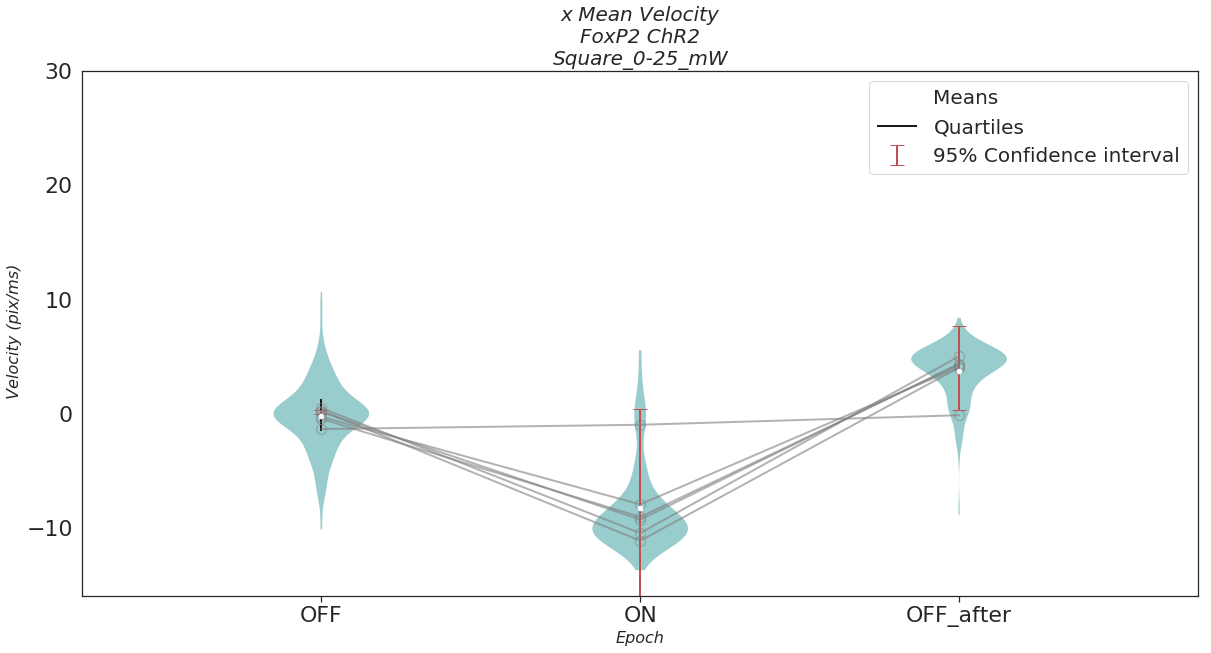

In [30]:
names = ['OFF','ON', 'OFF_after']
measure='Mean' #specify the measure for the ON-Laser Epoch
data_init =min_and_mean_on_off(epochs_all_mice,pre_interval,post_interval,interval,measure)
print('data_init =',data_init.shape)
violin_plot_summary(data_init,names,measure)
# plot_every_mouse_mean(epochs_mean_each_mouse)
plt.show()




# Plot the Pre Laser X Distribution

spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2


<Figure size 432x288 with 0 Axes>

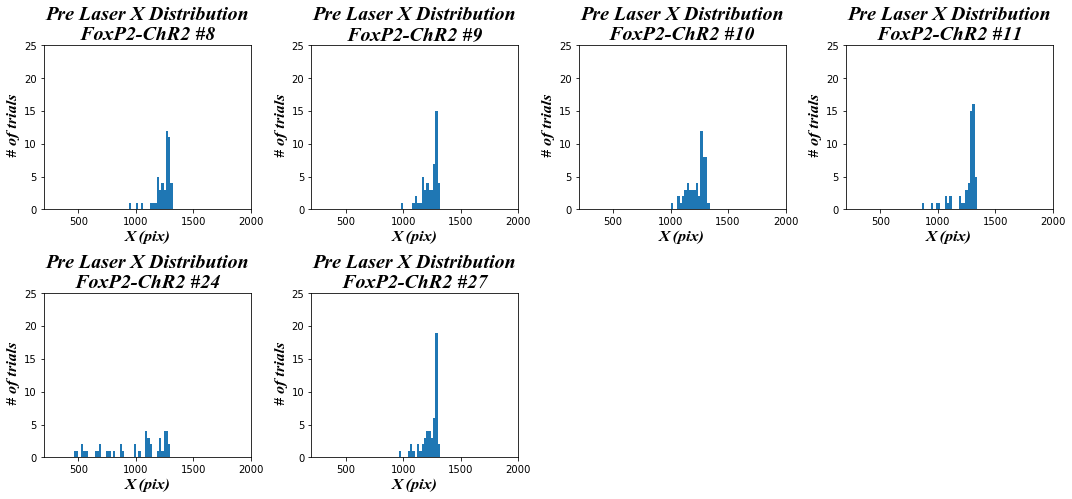

In [200]:
opto_par = 'ChR2'
# opto_par = 'Control'

## 1 mW intensity
folder = 'STR_Square_HI_1';  
# folder = 'STN_Square_HI_1'; #Vglut control folder's name
# folder = 'Square_HI_1';

## 0.5 mW intensity
folder = 'STR_Square_HI';  
# folder = 'STN_Square_HI'; #Vglut control folder's name
# folder = 'Square_HI';
# folder= 'Square_0-5_mW'

## 0.25 mW intensity
folder = 'Square_0-25_mW'

# mouse_type = 'Vglut'
# mouse_type = 'D2';
mouse_type = 'FoxP2'
folder_spont = 'Spontaneous'

pre_stim_inter = 10 # number of timebins in the pre-stimulus period 
# n_bins = 45
plt.figure(2)
fig = plt.figure(figsize=(15,10))
count = 0
min_x =200
max_y = 25 ; max_x = 2000
step = 20
bins_list = np.arange(0,max_x,step)
for n in FoxP2_list[0][:]: # Run over all the mice
    count +=1
    start = timeit.default_timer()
    mouse_no = n
    direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse

    files_list_DLC = list_all_files(direct+folder+'/DLC',extension)
    files_list_Laser = list_all_files(direct+folder+'/Laser',extension)

    pre_x_position_epochs = extract_pre_laser_x_epochs_over_trials(files_list_DLC,files_list_Laser,folder,'n', pre_stim_inter)
    pre_x_position = np.average(pre_x_position_epochs,axis = 1)
    
    x = fig.add_subplot(3,4,count)
    
    plt.hist(pre_x_position, bins=bins_list)
    plt.ylabel(" # of trials", fontproperties=font_label)
    plt.xlabel("X (pix)", fontproperties=font_label)
    plt.xlim(min_x,max_x) #set limits
    plt.ylim(0,max_y) #set limits
    plt.title("Pre Laser X Distribution"+"\n"+mouse_type+'-'+opto_par+' #'+str(mouse_no) , fontproperties=font)

plt.tight_layout()
plt.savefig(pre_direct+'Subplots'+'/Pre_laser_X_distribution_'+folder+"_"+opto_par+'_'+mouse_type+'_' +
            '.png',bbox_inches='tight',orientation='landscape',dpi=400)
plt.show()




# Plot One mouse

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
1
/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Square_0-5_mW_1_s
spont =n
 number of session = 1 out of 2
inconsistent right left =  0
# jitter in mean(righ,left)  =  1046
inconsistent right left =  239
# jitter in mean(righ,left)  =  2728
# discarded epochs = 9
 number of session = 2 out of 2
inconsistent right left =  0
# jitter in mean(righ,left)  =  1252
inconsistent right left =  178
# jitter in mean(righ,left)  =  2532
# discarded epochs = 3


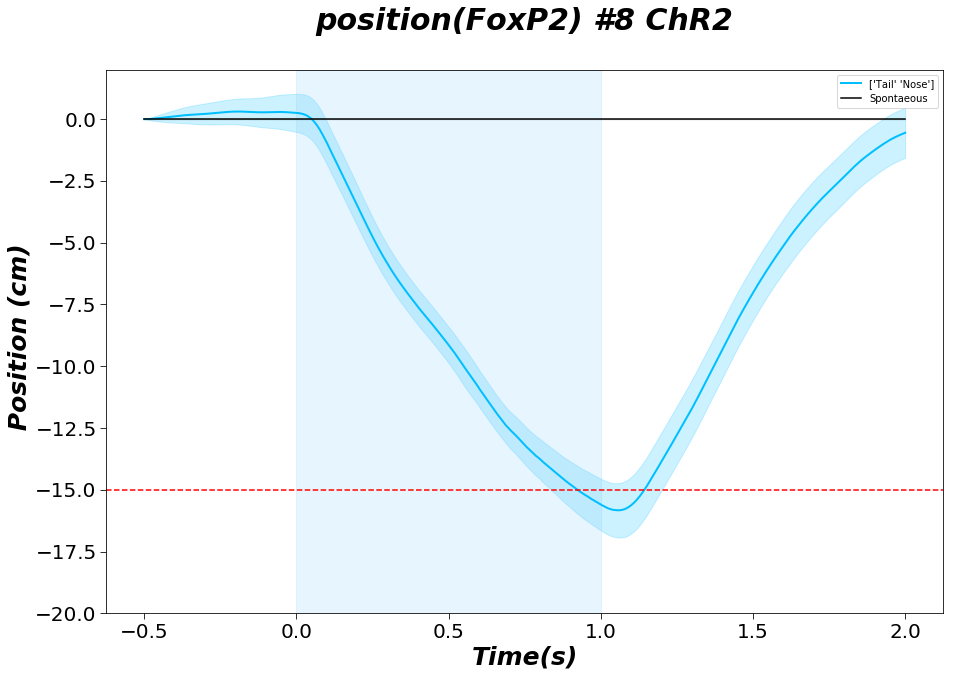

In [57]:
# where_plot,which_plot,what_plot = [1,2],0,1
where_plot,which_plot,what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user
# 

mouse_type= 'FoxP2';opto_par = "ChR2"; mouse_no = 8; spont = "n"; folder = "Square_0-5_mW_1_s"

if what_plot == 0:
    max_y_pre_post = 2; min_y_pre_post = -20
else :
    max_y_pre_post = 30; min_y_pre_post = -30
    
direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse
print(direct+folder)


files_list_DLC = list_all_files(direct+folder+'/DLC',extension)
files_list_Laser = list_all_files(direct+folder+'/Laser',extension)

#One session
# epochs = extract_epochs_over_trials([files_list_DLC[0]],[files_list_Laser[0]],direct,folder,spont)

# All sessions 
epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,spont,pre_interval,post_interval,interval)

epochs_spont = np.zeros(np.shape(epochs))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
# plot_pre_on_post(epochs[13,:],epochs_spont[10,:],average = 'n')
plot_pre_on_post(epochs,epochs_spont,average = 'n')



# Plot one laser stimulation

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
/home/shiva/Desktop/Shiva_Behavior/VGlut/ChR2/Mouse_116/Square_1_mW
spont =n
 number of session = 1 out of 1
inconsistent right left =  0
0
194
25.509239301286897
righ+left jitter =  1130
nan found? 0
inconsistent right left =  0
0
12
43.597898774344344
righ+left jitter =  1082
nan found? 0
# discarded epochs = 0


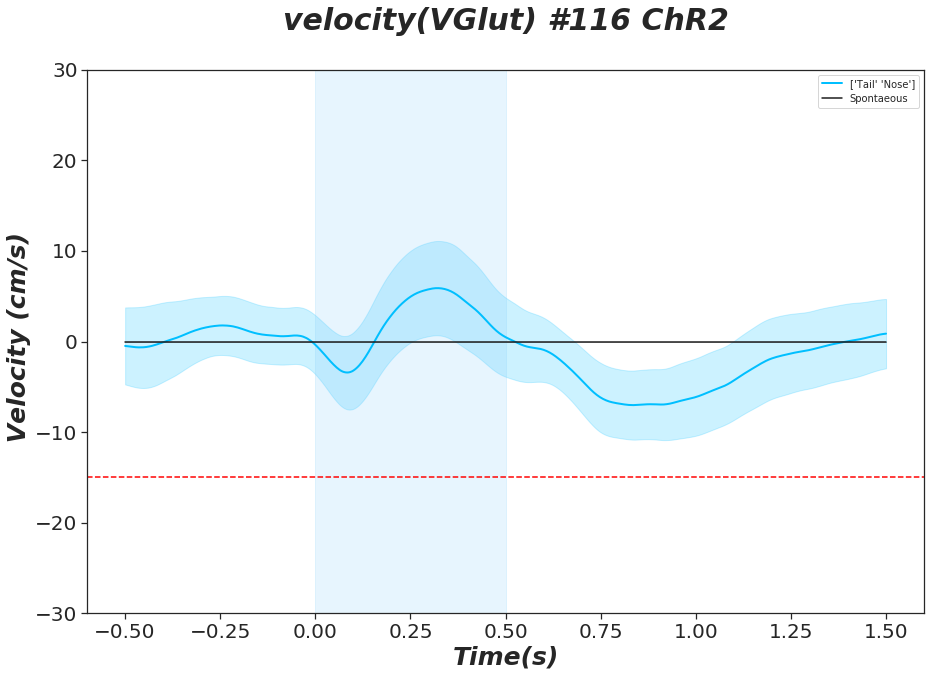

In [220]:
 return averaged_position

# where_plot,which_plot,what_plot = [1,2],0,1
where_plot,which_plot,what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user
# 
n_timebin = 30; window = 10; 
window_veloc = 5
max_accel = 95
mouse_type= 'VGlut';opto_par = "ChR2"; mouse_no = 116; spont = "n"; folder = "Square_1_mW"

if what_plot == 0:
    max_y_pre_post = 20; min_y_pre_post = -30
else :
    max_y_pre_post = 30; min_y_pre_post = -30
    
direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse
print(direct+folder)


files_list_DLC = list_all_files(direct+folder+'/DLC',extension)
files_list_Laser = list_all_files(direct+folder+'/Laser',extension)

epochs = extract_epochs_over_trials([files_list_DLC[0]],[files_list_Laser[0]],direct,folder,spont,pre_interval,post_interval,interval)
epochs_spont = np.zeros(np.shape(epochs))



what_plot = 1 # for velocity
pre_vel_epochs = extract_epochs_over_trials([files_list_DLC[0]],[files_list_Laser[0]],direct,folder,'n',pre_stim_inter,0,0)
#         pre_vel_epochs = extract_pre_laser_accel_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder, pre_stim_inter,n_timebin,window)
pre_vel = np.average(pre_vel_epochs[:,:pre_stim_inter],axis = 1)
print(pre_vel.shape)
ind_negative_accel = np.array(np.where(pre_vel < 0)).T
ind_negative_accel =  ind_negative_accel.reshape( ind_negative_accel.shape[0],)
ind_positive_accel = np.array(np.where(pre_vel>0)).T
ind_positive_accel =  ind_positive_accel.reshape( ind_positive_accel.shape[0],)
print("#positive accel={}".format(len(ind_positive_accel)))
print("#negative accel={}".format(len(ind_negative_accel)))
print(np.average(epochs[:pre_interval,:],axis = 1)[ind_negative_accel])
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
# plot_pre_on_post(epochs[13,:],epochs_spont[10,:],average = 'n')
# plot_pre_on_post(epochs,epochs_spont,average = 'n')


# Blah Blah

In [73]:
a = np.arange(10)

take = np.hstack((np.arange(1,3),np.arange(2,6))) 
print((set(take)))
print(np.take(a, sorted(set(take))))
print(a[take])

{1, 2, 3, 4, 5}
[1 2 3 4 5]
[1 2 2 3 4 5]


In [ ]:
# to plot points on violin plot in V/X distinction
# sns.swarmplot(x="epoch", y="mean_velocity",ax = ax1,
#                 hue="x",
#                 data=result_pos, color="r", edgecolor="g", size = 6,
#                 hue_order=['front','back'])

# sns.swarmplot(x="epoch", y="mean_velocity",ax = ax2,
#                 hue="x",
#                 data=result_neg, color="r", edgecolor="g", size = 6,
#                 hue_order=['front','back'])


# x_series = [0.3,0.6]
# xposlist = [ 0, 0.5]
# for i in range(0,2):
#     ax2.text(xposlist[i], 10, stringlist[i])
    
# for i in range(2,4):
#     ax1.text(xposlist[i-2], 10, stringlist[i])



In [ ]:
# to have two plots in each subplot

#     fig = plt.figure(figsize=(20,15))
#     outer = gridspec.GridSpec(3, 4, wspace=0.2, hspace=0.2)


#     inner = gridspec.GridSpecFromSubplotSpec(1, 2,
        #                     subplot_spec=outer[count-1], wspace=0.1, hspace=0.1)
        #     ax = plt.Subplot(fig, inner[0])
        #     fig.add_subplot(ax)
        #     plot_pre_on_post(epochs[ind_negative_accel,:],epochs_spont,average = 'Averg_trials')

            #############################################

        #     ax = plt.Subplot(fig, inner[1])
        #     fig.add_subplot(ax)
        #     plot_pre_on_post(epochs[ind_positive_accel,:],epochs_spont,average = 'Averg_trials')


    # plt.suptitle('D2 Cre '+'\n'+'intensity='+intensity+' mW'+'pre stim window='+str(pre_stim_inter),fontsize= 30,y = 1)
    # plt.tight_layout()
    # plt.savefig(pre_direct+'Subplots'+'/Pre_laser_accel_distinction_'+opto_par+'_'+mouse_type+'_' +
    #             '.png',bbox_inches='tight',orientation='landscape',dpi=400)
    # # plt.savefig(pre_direct+'Subplots'+'/Pre_laser_x_distinction_'+opto_par+'_'+mouse_type+'_' +
    # #             '.png',bbox_inches='tight',orientation='landscape',dpi=400)
    # plt.show()
   

In [72]:
#%% 
#################################    Spontaneous vs. Stimulated     #####################################################
################################# Tail/Nose velocity  ###############################################
#
#
####%%%%%%%%%%%%%%%% |||| Choose either Nose or Tail ||||||| %%%%%%%%%%%%%5%%
#param = 'Nose'
##param = 'Tail' 
#
####%%%%%%%%%%%%%%%% |||| Choose either x or y ||||||| %%%%%%%%%%%%%5%%
#cor = 'x'
##cor = 'y' 
###%%%%%%%%%%%%%%%%
#cor_mean_stim =  (df[('r'+param,cor)]+ df[('l'+param,cor)])/2
#velocity = (cor_mean_stim - shift(cor_mean_stim, n_timebin, cval=cor_mean_stim[0]))/ n_timebin
#
#cor_mean_spont =  (df_spont[('r'+param,cor)]+ df_spont[('l'+param,cor)])/2 # average the position of spontaneous position for left and right images
#velocity_spont = (cor_mean_spont - shift(cor_mean_spont, n_timebin, cval=cor_mean_spont[0]))/ n_timebin # velocity derived over n_timebin interval
#time_end = min(len(time_series),len(time_series_spont)) # where to end the plot 
#plt.figure(2)
#plt.plot(time_series[:time_end]+n_timebin/fps, velocity[:time_end], 'navy', linewidth = 0.8, label = 'Stimulated')
#
#plt.axhline(y = 0, color = 'r', linewidth = 0.7) # plot zero velocity threshold
#plt.plot(time_series_spont[:time_end]+n_timebin/fps, velocity_spont[:time_end], 'orange', linewidth = 0.8, label = 'Spontaneous')
#
#plt.ylabel(" Velocity (pix/s)", fontproperties=font_label)
#plt.xlabel("Time(s)", fontproperties=font_label)
#plt.title(param+' ' + cor+ " Velocity ("+ str(n_timebin) +' frame interval) #'+str(mouse_no), fontproperties=font)
#
#min_end = min(min(velocity),min(velocity_spont))
#max_end = max(max(velocity),max(velocity_spont))
#plt.ylim(min_end,max_end) #set limits
#plt.xlim(n_timebin/fps, trial_time_spont/2) # look at half of trial to see better details
#plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'gray', linewidth = 0.3)# plot stimulus onsets
#plt.legend(fontsize = 10)
#plt.savefig(direct+'/Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_'+ param + '_' + cor+ '_Velociy_' +str(n_timebin)+ '_interval_stim_vs_spont_trial'+str(trial_spont)+'.png',bbox_inches='tight',orientation='landscape',dpi=400)


In [3]:

# General parameters
opto_par = 'ChR2'
# opto_par = 'Control'
trial_no =38 # specify trial number
mouse_no = 8 # specify mouse number
stim_power = 1
trial_spont = 25 
stim_type = 'Square'
# stim_type = 'Square_HI_1'
#############################################
# brain_region = 'STR'
# brain_region_alone = 'STR_alone'
# mouse_type = 'D2'
############################################
brain_region = 'STR';brain_region_alone = 'STN_alone'; mouse_type = 'Vglut'
trial_let = 'b18' # specify trial number
trial_let_spont = 'b_02'
#############################################
brain_region = ''
brain_region_alone = brain_region
mouse_type = 'FoxP2'

# pre_direct = 'C:/Users/P-P1-PNH5/Desktop/Shiva_Behavior/' # folder


#######################################################################################################################################
# files_list = list_all_data_files(direct+'Spontaneous/DLC',extension)

# #################### VGlut 164-165
# file_name_spont = direct+'Spontaneous/DLC/'+mouse_type+str(mouse_no)+ '_' 'spon_act_'+ trial_let_spont+'_DLC.xlsx'
# file_name_laser = direct +brain_region+'_' +stim_type+ '_HI_1'+'/Laser/'+mouse_type+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_square_pulses_'+trial_let+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+brain_region+'_' +stim_type+ '_HI_1'+ '/DLC/'+mouse_type+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_square_pulses_'+trial_let+ '_DLC.xlsx' # name of your excel file
# ##################### VGlut  116-119-166
# file_name_spont = direct+'Spontaneous/DLC/Mouse'+str(mouse_no)+'_' + 'spon_act_trial'+ str(trial_spont)+'_DLC.xlsx'
# file_name_laser = direct+brain_region+'_' +stim_type+ '_HI_1'+'/Laser/Mouse'+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+brain_region+'_' +stim_type+ '_HI_1'+ '/DLC/Mouse'+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_DLC.xlsx' # name of your excel file

# ##################### D2
# file_name_spont = direct+'Spontaneous/DLC/Mouse'+str(mouse_no)+'_' + 'spon_act_trial'+ str(trial_spont)+'_DLC.xlsx'
# file_name_laser = direct+ brain_region+'_' +stim_type+ '_HI_1'+'/Laser/Mouse'+str(mouse_no)+'_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+ brain_region+'_' +stim_type+ '_HI_1'+'/DLC/Mouse'+str(mouse_no)+'_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+'_DLC.xlsx' # name of your excel file

##################### FoxP2Cre
# file_name_spont = 'Mouse' + mouse_type+ '_#'+str(mouse_no)+'/Spontaneous/DLC/Mouse'+str(mouse_no)+'_' + 'spon_act_trial'+ str(trial_spont)+'_DLC.xlsx'
# file_name_laser = direct+ '/Laser/MouseFoxP2_Cre_#'+str(mouse_no)+ '_'+stim_type+'Pulse_'+str(stim_power)+'mW_' +trial_let+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+'_/'+stim_type+ '_HI_1/'+DLC/MouseFoxP2Cre_#'+str(mouse_no)+'_'+stim_type+'Pulse_'+str(stim_power)+'mW_' +trial_let+ '_DLC.xlsx' # name of your excel file



/home/shiva/Behavioral-Analysis
